# Position Trading - Fundamental + Technical Entry System

Strategy:
- Find high-quality growth stocks (fundamentals)
- Identify optimal entry prices (technical pullbacks)
- Set price alerts with momentum confirmation
- Trade alongside index funds

In [32]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from data_fetcher import StockDataFetcher
from indicators import sma, ema, rsi, adx, atr, cmf

plt.style.use('seaborn-v0_8-darkgrid')

## Market Regime Detection

Check overall market health before making individual stock decisions.

In [33]:
from market.regime import check_market_health

# Check market regime before scanning stocks
market_regime = check_market_health(verbose=True, check_breadth=False)

/Users/jaspervalk/Documents/market-analysis/notebooks/../src/market/regime.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, progress=False)
/Users/jaspervalk/Documents/market-analysis/notebooks/../src/market/regime.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, progress=False)


MARKET REGIME ANALYSIS

Regime: BULL
Confidence: 100%
Recommendation: BUY signals are valid

Details:
  [HEALTHY] SPY above 50 & 200 MA (uptrend)
  [HEALTHY] QQQ above 50 & 200 MA (uptrend)
  [HEALTHY] VIX 19.8 (normal - healthy)


/Users/jaspervalk/Documents/market-analysis/notebooks/../src/market/regime.py:36: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, progress=False)


## Fundamental Analysis Functions

In [34]:
def get_fundamentals(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Revenue growth
        revenue_growth = info.get('revenueGrowth', 0) * 100 if info.get('revenueGrowth') else None
        quarterly_revenue_growth = info.get('quarterlyRevenueGrowth', 0) * 100 if info.get('quarterlyRevenueGrowth') else None
        
        # Margins
        gross_margin = info.get('grossMargins', 0) * 100 if info.get('grossMargins') else None
        operating_margin = info.get('operatingMargins', 0) * 100 if info.get('operatingMargins') else None
        
        # Valuation
        pe_ratio = info.get('trailingPE', None)
        peg_ratio = info.get('pegRatio', None)
        ps_ratio = info.get('priceToSalesTrailing12Months', None)
        
        # Profitability
        is_profitable = info.get('trailingEps', 0) > 0
        
        return {
            'revenue_growth_yoy': revenue_growth,
            'revenue_growth_qoq': quarterly_revenue_growth,
            'gross_margin': gross_margin,
            'operating_margin': operating_margin,
            'pe_ratio': pe_ratio,
            'peg_ratio': peg_ratio,
            'ps_ratio': ps_ratio,
            'is_profitable': is_profitable,
            'market_cap': info.get('marketCap', 0)
        }
    except:
        return None


def calculate_fundamental_score(fundamentals):
    if not fundamentals:
        return 0, ["No fundamental data available"], []
    
    score = 0
    reasons = []
    warnings = []
    
    # Revenue growth (0-40 points)
    rev_growth = fundamentals.get('revenue_growth_yoy')
    if rev_growth:
        if rev_growth > 50:
            score += 40
            reasons.append(f"Exceptional revenue growth ({rev_growth:.1f}% YoY)")
        elif rev_growth > 30:
            score += 35
            reasons.append(f"Strong revenue growth ({rev_growth:.1f}% YoY)")
        elif rev_growth > 20:
            score += 25
            reasons.append(f"Good revenue growth ({rev_growth:.1f}% YoY)")
        elif rev_growth > 10:
            score += 15
            reasons.append(f"Moderate revenue growth ({rev_growth:.1f}% YoY)")
        else:
            reasons.append(f"Slow revenue growth ({rev_growth:.1f}% YoY)")
    
    # Gross margin (0-25 points)
    gross_margin = fundamentals.get('gross_margin')
    if gross_margin:
        if gross_margin > 70:
            score += 25
            reasons.append(f"Excellent gross margin ({gross_margin:.1f}%)")
        elif gross_margin > 50:
            score += 20
            reasons.append(f"Strong gross margin ({gross_margin:.1f}%)")
        elif gross_margin > 30:
            score += 10
            reasons.append(f"Decent gross margin ({gross_margin:.1f}%)")
        else:
            reasons.append(f"Low gross margin ({gross_margin:.1f}%)")
    
    # Operating margin (0-20 points)
    op_margin = fundamentals.get('operating_margin')
    if op_margin:
        if op_margin > 20:
            score += 20
            reasons.append(f"Highly profitable (Op margin {op_margin:.1f}%)")
        elif op_margin > 10:
            score += 15
            reasons.append(f"Profitable (Op margin {op_margin:.1f}%)")
        elif op_margin > 0:
            score += 10
            reasons.append(f"Marginally profitable (Op margin {op_margin:.1f}%)")
        else:
            reasons.append(f"Not yet profitable (Op margin {op_margin:.1f}%)")
    
    # Quarterly momentum (0-15 points)
    qoq_growth = fundamentals.get('revenue_growth_qoq')
    if qoq_growth:
        if qoq_growth > 20:
            score += 15
            reasons.append(f"Accelerating growth ({qoq_growth:.1f}% QoQ)")
        elif qoq_growth > 10:
            score += 10
            reasons.append(f"Steady growth ({qoq_growth:.1f}% QoQ)")
    
    # VALUATION WARNINGS
    pe = fundamentals.get('pe_ratio')
    if pe:
        if pe > 100:
            warnings.append(f"WARNING: Very expensive (P/E {pe:.0f}) - priced for perfection")
        elif pe > 50:
            warnings.append(f"WARNING: Expensive (P/E {pe:.0f}) - high expectations")
        elif pe > 30:
            warnings.append(f"P/E {pe:.0f} (reasonable for growth)")
    
    peg = fundamentals.get('peg_ratio')
    if peg:
        if peg > 2:
            warnings.append(f"WARNING: PEG ratio {peg:.1f} (overvalued relative to growth)")
        elif peg < 1:
            warnings.append(f"Good value: PEG ratio {peg:.1f}")
    
    ps = fundamentals.get('ps_ratio')
    if ps:
        if ps > 20:
            warnings.append(f"WARNING: Price/Sales {ps:.1f} (very expensive)")
        elif ps > 10:
            warnings.append(f"Price/Sales {ps:.1f} (expensive but ok for growth)")
    
    return score, reasons, warnings

## Entry Level Calculation

In [35]:
def calculate_entry_levels(df):
    current = df.iloc[-1]
    current_price = current['Close']
    
    # Support levels
    sma_20 = current['SMA_20']
    sma_50 = current['SMA_50']
    
    # Recent lows (support)
    recent_low = df['Low'].tail(20).min()
    
    # Fibonacci retracement from recent swing
    recent_high = df['High'].tail(60).max()
    recent_swing_low = df['Low'].tail(60).min()
    fib_50 = recent_high - (recent_high - recent_swing_low) * 0.5
    fib_618 = recent_high - (recent_high - recent_swing_low) * 0.618
    
    # Distance from current price
    levels = []
    
    # Conservative: 20-day MA
    if sma_20 < current_price:
        levels.append({
            'price': sma_20,
            'type': 'Conservative (20-day MA)',
            'distance_pct': ((sma_20 - current_price) / current_price) * 100
        })
    
    # Moderate: 50-day MA or Fib 50%
    if sma_50 < current_price:
        levels.append({
            'price': sma_50,
            'type': 'Moderate (50-day MA)',
            'distance_pct': ((sma_50 - current_price) / current_price) * 100
        })
    
    if fib_50 < current_price:
        levels.append({
            'price': fib_50,
            'type': 'Moderate (Fib 50%)',
            'distance_pct': ((fib_50 - current_price) / current_price) * 100
        })
    
    # Aggressive: Buy now if breaking out
    high_20d = df['High'].tail(20).max()
    if current_price >= high_20d * 0.98:  # Within 2% of high
        levels.append({
            'price': current_price,
            'type': 'Aggressive (Breakout now)',
            'distance_pct': 0
        })
    
    # Sort by distance (closest first)
    levels.sort(key=lambda x: abs(x['distance_pct']))
    
    return levels


def check_entry_conditions(df, target_price):
    current = df.iloc[-1]
    
    conditions = []
    met = 0
    total = 4
    
    # 1. Price near target
    price_diff = abs((current['Close'] - target_price) / target_price) * 100
    if price_diff < 2:
        conditions.append(('Price at target', True))
        met += 1
    else:
        conditions.append((f'Price {price_diff:.1f}% from target', False))
    
    # 2. RSI not overbought
    if current['RSI'] < 60:
        conditions.append((f'RSI {current["RSI"]:.0f} (good)', True))
        met += 1
    else:
        conditions.append((f'RSI {current["RSI"]:.0f} (wait)', False))
    
    # 3. Trend still strong
    if current['ADX'] > 20:
        conditions.append((f'ADX {current["ADX"]:.0f} (trending)', True))
        met += 1
    else:
        conditions.append((f'ADX {current["ADX"]:.0f} (weak)', False))
    
    # 4. Volume confirmation
    vol_ratio = current['Volume'] / current['Volume_SMA']
    if vol_ratio > 1.0:
        conditions.append((f'Volume {vol_ratio:.1f}x (good)', True))
        met += 1
    else:
        conditions.append((f'Volume {vol_ratio:.1f}x (low)', False))
    
    return conditions, met, total

## Full Stock Analysis

In [36]:
def analyze_stock(ticker, fetcher, market_regime=None):
    print(f"\nAnalyzing {ticker}...")
    print("="*60)
    
    # Get fundamental data
    fundamentals = get_fundamentals(ticker)
    fund_score, fund_reasons, warnings = calculate_fundamental_score(fundamentals)
    
    # Get technical data
    df = fetcher.fetch(ticker, period='1y')
    if df is None or len(df) < 60:
        print("Insufficient data")
        return None
    
    df['SMA_20'] = sma(df['Close'], 20)
    df['SMA_50'] = sma(df['Close'], 50)
    df['RSI'] = rsi(df['Close'], 14)
    
    adx_data = adx(df['High'], df['Low'], df['Close'], 14)
    df['ADX'] = adx_data['ADX']
    df['Plus_DI'] = adx_data['Plus_DI']
    df['Minus_DI'] = adx_data['Minus_DI']
    
    df['CMF'] = cmf(df['High'], df['Low'], df['Close'], df['Volume'], 20)
    df['Volume_SMA'] = df['Volume'].rolling(20).mean()
    df['ATR'] = atr(df['High'], df['Low'], df['Close'], 14)
    
    df = df.dropna()
    current = df.iloc[-1]
    current_price = current['Close']
    
    # Calculate entry levels
    entry_levels = calculate_entry_levels(df)
    
    # Display results
    print(f"\nCURRENT PRICE: ${current_price:.2f}")
    print(f"\nFUNDAMENTALS (Score: {fund_score}/100)")
    for reason in fund_reasons:
        print(f"  {reason}")
    
    if warnings:
        print(f"\nVALUATION WARNINGS:")
        for warning in warnings:
            print(f"  {warning}")
    
    print(f"\nTECHNICAL STATUS:")
    print(f"  RSI: {current['RSI']:.0f}")
    print(f"  ADX: {current['ADX']:.0f}")
    print(f"  Trend: {'Bullish' if current['Plus_DI'] > current['Minus_DI'] else 'Bearish'}")
    print(f"  20-day MA: ${current['SMA_20']:.2f}")
    print(f"  50-day MA: ${current['SMA_50']:.2f}")
    
    # Determine recommendation
    if fund_score < 40:
        print(f"\nRECOMMENDATION: SKIP")
        print(f"Reason: Weak fundamentals (score {fund_score}/100)")
        return None
    
    # Check if good entry now
    # Good entry = oversold bounce OR at MA support with momentum
    is_oversold_bounce = 30 < current['RSI'] < 50  # Bouncing from oversold
    at_20ma_support = abs(current_price - current['SMA_20']) / current['SMA_20'] < 0.03  # Within 3% of 20MA
    at_50ma_support = abs(current_price - current['SMA_50']) / current['SMA_50'] < 0.03  # Within 3% of 50MA
    has_momentum = current['ADX'] > 20  # Trending
    not_overbought = current['RSI'] < 65

    # Buy conditions: Strong fundamentals + (oversold bounce OR MA support) + momentum
    buy_on_oversold = is_oversold_bounce and has_momentum and fund_score >= 70
    buy_on_support = (at_20ma_support or at_50ma_support) and not_overbought and has_momentum and fund_score >= 60

    # MARKET REGIME OVERRIDE
    market_is_healthy = market_regime is None or market_regime.get('healthy', True)
    
    if (buy_on_oversold or buy_on_support) and market_is_healthy:
        print(f"\nRECOMMENDATION: BUY NOW")
        if buy_on_oversold:
            print(f"Reason: Oversold bounce with strong fundamentals (RSI {current['RSI']:.0f})")
        else:
            print(f"Reason: At MA support with good momentum")
        
        entry = current_price
        stop = entry - (2 * current['ATR'])
        target = entry + (3 * current['ATR'])
        
        print(f"\nTRADE SETUP:")
        print(f"  Entry: ${entry:.2f}")
        print(f"  Stop: ${stop:.2f} (-{((entry-stop)/entry)*100:.1f}%)")
        print(f"  Target: ${target:.2f} (+{((target-entry)/entry)*100:.1f}%)")
        
        return {
            'ticker': ticker,
            'action': 'BUY NOW',
            'fund_score': fund_score,
            'current_price': current_price,
            'entry_price': entry,
            'stop': stop,
            'target': target
        }
    
    elif (buy_on_oversold or buy_on_support) and not market_is_healthy:
        # Stock looks good but market is unhealthy
        print(f"\nRECOMMENDATION: WAIT - MARKET REGIME OVERRIDE")
        print(f"Reason: Stock setup is good but market regime is {market_regime.get('regime', 'unhealthy').upper()}")
        print(f"Market: {market_regime.get('recommendation', 'Wait for better market conditions')}")
        
        best_entry = entry_levels[0]['price'] if entry_levels else current_price * 0.95
        return {
            'ticker': ticker,
            'action': 'WAIT (MARKET)',
            'fund_score': fund_score,
            'current_price': current_price,
            'best_entry': best_entry,
            'alert_price': best_entry,
            'market_blocked': True
        }
    
    else:
        print(f"\nRECOMMENDATION: WAIT FOR PULLBACK")
        if current['RSI'] > 65:
            print(f"Reason: RSI {current['RSI']:.0f} is overbought")
        elif current['RSI'] < 30:
            print(f"Reason: RSI {current['RSI']:.0f} too oversold, wait for bounce above 30")
        elif current['ADX'] < 20:
            print(f"Reason: ADX {current['ADX']:.0f} too weak, no clear trend")
        else:
            print(f"Reason: Wait for better entry at support levels")
        
        if entry_levels:
            print(f"\nENTRY LEVELS (wait for pullback):")
            for i, level in enumerate(entry_levels[:3], 1):
                print(f"\n  Level {i}: ${level['price']:.2f} ({level['type']})")
                print(f"    Current: ${current_price:.2f} -> Target: ${level['price']:.2f} ({level['distance_pct']:+.1f}%)")
                
                conditions, met, total = check_entry_conditions(df, level['price'])
                print(f"    When price reaches ${level['price']:.2f}, confirm:")
                for condition, is_met in conditions:
                    status = 'YES' if is_met else 'NO'
                    print(f"      [{status}] {condition}")
                
                if i == 1:
                    print(f"    -> SET ALERT: ${level['price']:.2f}")
        
        best_entry = entry_levels[0]['price'] if entry_levels else current_price * 0.95
        return {
            'ticker': ticker,
            'action': 'WAIT',
            'fund_score': fund_score,
            'current_price': current_price,
            'best_entry': best_entry,
            'alert_price': best_entry
        }

## Scan Watchlist

In [ ]:
fetcher = StockDataFetcher()

watchlist = [
    'HIMS', 'SOFI', 'DDOG', 'NET', 'MDB', 'DOCS', 'DASH', 'ABNB', 'HIVE', 'NVDA',
    'IREN', 'MELI', 'MSTR', 'BBAI', 'OUST', 'ADBE', 'ROOT', 'NBIS', 'TSM', 'AIR',
    'CRWD', 'SNOW', 'PLTR', 'SHOP', 'COIN', 'RBLX', 'U', 'RIVN', 'LCID', 'HOOD',
    'UPST', 'AFRM', 'ZM', 'DOCU', 'META', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA',
    'UNH', 'DKNG', 'NOW', 'ZYME', 'LRCX', 'AMAT', 'APLD', 'DUOL', 'MRVL'
]

results = []
for ticker in watchlist:
    result = analyze_stock(ticker, fetcher, market_regime)
    if result:
        results.append(result)

print("\n" + "="*60)
print("SUMMARY - TRADING ALERTS")
print("="*60)

# Show market regime status
if market_regime:
    print(f"\nMARKET REGIME: {market_regime['regime'].upper()} ({market_regime['confidence']:.0f}% confidence)")
    print(f"{market_regime['recommendation']}")
    print("="*60)

buy_now = [r for r in results if r['action'] == 'BUY NOW']
wait = [r for r in results if r['action'] == 'WAIT']
market_blocked = [r for r in results if r['action'] == 'WAIT (MARKET)']

if buy_now:
    print(f"\nBUY NOW ({len(buy_now)} stocks):")
    for r in buy_now:
        print(f"  {r['ticker']}: ${r['current_price']:.2f} (Fund Score: {r['fund_score']})")

if market_blocked:
    print(f"\nGOOD STOCKS - BLOCKED BY MARKET ({len(market_blocked)} stocks):")
    print(f"These stocks have good setups but market regime prevents buying:")
    for r in market_blocked:
        print(f"  {r['ticker']}: ${r['current_price']:.2f} (Fund Score: {r['fund_score']}) - Wait for market to improve")

if wait:
    print(f"\nWATCH LIST - Set Alerts ({len(wait)} stocks):")
    print(f"\nFormat: TICKER: Current $X.XX -> Alert at $X.XX (pullback target)")
    print("-"*60)
    wait_sorted = sorted(wait, key=lambda x: x['fund_score'], reverse=True)
    for r in wait_sorted:
        pullback_pct = ((r['alert_price'] - r['current_price']) / r['current_price']) * 100
        print(f"  {r['ticker']}: Current ${r['current_price']:.2f} -> Alert ${r['alert_price']:.2f} ({pullback_pct:+.1f}%) [Score: {r['fund_score']}]")

print("\n" + "="*60)
print("INSTRUCTIONS:")
print("="*60)
print("1. BUY NOW: Enter positions today (if market regime allows)")
print("2. MARKET BLOCKED: Good stocks but wait for market to stabilize")
print("3. WATCH LIST: Set price alerts at the 'Alert' price")
print("4. When alert triggers: Re-check market regime + momentum")
print("5. If both confirm: Enter position")


Analyzing HIMS...
Fetching HIMS data...
Got 250 days of data

CURRENT PRICE: $36.98

FUNDAMENTALS (Score: 70/100)
  Strong revenue growth (49.2% YoY)
  Excellent gross margin (75.0%)
  Marginally profitable (Op margin 2.1%)

VALUATION WARNINGS:

TECHNICAL STATUS:
  RSI: 18
  ADX: 45
  Trend: Bearish
  20-day MA: $44.16
  50-day MA: $50.63

RECOMMENDATION: WAIT FOR PULLBACK
Reason: RSI 18 too oversold, wait for bounce above 30

Analyzing SOFI...
Fetching SOFI data...
Got 250 days of data

CURRENT PRICE: $27.82

FUNDAMENTALS (Score: 75/100)
  Strong revenue growth (37.8% YoY)
  Excellent gross margin (82.5%)
  Profitable (Op margin 15.6%)

VALUATION WARNINGS:
  P/E 50 (reasonable for growth)
  Price/Sales 10.4 (expensive but ok for growth)

TECHNICAL STATUS:
  RSI: 45
  ADX: 14
  Trend: Bearish
  20-day MA: $29.42
  50-day MA: $28.12

RECOMMENDATION: WAIT FOR PULLBACK
Reason: ADX 14 too weak, no clear trend

ENTRY LEVELS (wait for pullback):

  Level 1: $27.81 (Moderate (Fib 50%))
    C

## Extended Analysis Dashboard

Deep dive into the results with insights and statistics

In [38]:
# Extended Dashboard
import pandas as pd

print("="*80)
print("EXTENDED ANALYSIS DASHBOARD")
print("="*80)

# 1. Market Context
print("\n" + "="*80)
print("1. MARKET CONTEXT")
print("="*80)

if market_regime:
    checks = market_regime.get('checks', {})
    
    print(f"\nMarket Regime: {market_regime['regime'].upper()}")
    print(f"Confidence: {market_regime['confidence']:.0f}%")
    print(f"Recommendation: {market_regime['recommendation']}")
    
    print("\nMarket Health Indicators:")
    if 'spy' in checks:
        spy = checks['spy']
        print(f"  SPY: ${spy['price']:.2f} | 50-day: ${spy['sma_50']:.2f} | 200-day: ${spy['sma_200']:.2f} | Trend: {spy['trend']}")
    
    if 'qqq' in checks:
        qqq = checks['qqq']
        print(f"  QQQ: ${qqq['price']:.2f} | 50-day: ${qqq['sma_50']:.2f} | 200-day: ${qqq['sma_200']:.2f} | Trend: {qqq['trend']}")
    
    if 'vix' in checks:
        vix = checks['vix']
        print(f"  VIX: {vix['level']:.1f} | Status: {vix['status'].upper()} | {vix['reason']}")
    
    print("\nInterpretation:")
    if market_regime['regime'] == 'bull':
        print("  Market is healthy. Individual stock signals are reliable.")
        print("  Focus on BUY NOW opportunities.")
    elif market_regime['regime'] == 'neutral':
        print("  Market showing mixed signals. Trade with caution.")
        print("  Prefer stocks with strong fundamentals (score >= 70).")
        print("  Consider smaller position sizes.")
    elif market_regime['regime'] == 'correction':
        print("  Market is correcting. High risk for new positions.")
        print("  Build watchlist but WAIT for market to stabilize.")
        print("  Consider switching to 02.2_crisis_buying.ipynb for opportunities.")
    else:  # bear
        print("  BEAR MARKET ACTIVE. Do NOT use this notebook.")
        print("  Switch to 02.2_crisis_buying.ipynb to buy quality at discounts.")

# 2. Portfolio Analysis
print("\n" + "="*80)
print("2. PORTFOLIO ANALYSIS")
print("="*80)

buy_now = [r for r in results if r['action'] == 'BUY NOW']
wait = [r for r in results if r['action'] == 'WAIT']
market_blocked = [r for r in results if r['action'] == 'WAIT (MARKET)']

total_analyzed = len(results)
total_buy = len(buy_now)
total_wait = len(wait)
total_blocked = len(market_blocked)

print(f"\nScanned: {total_analyzed} stocks")
print(f"  BUY NOW: {total_buy} stocks ({total_buy/total_analyzed*100:.1f}%)")
print(f"  MARKET BLOCKED: {total_blocked} stocks ({total_blocked/total_analyzed*100:.1f}%)")
print(f"  WATCH LIST: {total_wait} stocks ({total_wait/total_analyzed*100:.1f}%)")

if buy_now:
    avg_fund_score = sum(r['fund_score'] for r in buy_now) / len(buy_now)
    avg_upside = sum(((r['target'] - r['entry_price']) / r['entry_price'] * 100) for r in buy_now) / len(buy_now)
    avg_risk = sum(((r['entry_price'] - r['stop']) / r['entry_price'] * 100) for r in buy_now) / len(buy_now)
    
    print(f"\nBUY NOW Statistics:")
    print(f"  Average Quality Score: {avg_fund_score:.0f}/100")
    print(f"  Average Upside: +{avg_upside:.1f}%")
    print(f"  Average Risk: -{avg_risk:.1f}%")
    print(f"  Risk/Reward Ratio: 1:{avg_upside/avg_risk:.1f}")

# 3. Quality Breakdown
print("\n" + "="*80)
print("3. QUALITY BREAKDOWN")
print("="*80)

# Categorize by quality score
elite = [r for r in results if r['fund_score'] >= 80]
strong = [r for r in results if 70 <= r['fund_score'] < 80]
good = [r for r in results if 60 <= r['fund_score'] < 70]
moderate = [r for r in results if 50 <= r['fund_score'] < 60]
weak = [r for r in results if r['fund_score'] < 50]

print(f"\nFundamental Quality Distribution:")
print(f"  Elite (80-100):    {len(elite):2d} stocks - {[r['ticker'] for r in elite]}")
print(f"  Strong (70-79):    {len(strong):2d} stocks - {[r['ticker'] for r in strong]}")
print(f"  Good (60-69):      {len(good):2d} stocks - {[r['ticker'] for r in good]}")
print(f"  Moderate (50-59):  {len(moderate):2d} stocks - {[r['ticker'] for r in moderate]}")
print(f"  Weak (< 50):       {len(weak):2d} stocks - {[r['ticker'] for r in weak]}")

print("\nFocus Recommendation:")
if elite:
    print(f"  PRIORITY: {len(elite)} ELITE quality stocks available")
    print(f"  Tickers: {', '.join([r['ticker'] for r in elite])}")
if strong:
    print(f"  STRONG: {len(strong)} stocks with 70+ scores")
    print(f"  Tickers: {', '.join([r['ticker'] for r in strong])}")

# 4. Top Opportunities
print("\n" + "="*80)
print("4. TOP OPPORTUNITIES")
print("="*80)

# Best buys now (if any)
if buy_now:
    print(f"\nBest BUY NOW Opportunities:")
    buy_sorted = sorted(buy_now, key=lambda x: x['fund_score'], reverse=True)
    for i, r in enumerate(buy_sorted, 1):
        upside = ((r['target'] - r['entry_price']) / r['entry_price']) * 100
        risk = ((r['entry_price'] - r['stop']) / r['entry_price']) * 100
        print(f"\n  #{i}. {r['ticker']}")
        print(f"      Quality Score: {r['fund_score']}/100")
        print(f"      Entry: ${r['entry_price']:.2f}")
        print(f"      Target: ${r['target']:.2f} (+{upside:.1f}%)")
        print(f"      Stop: ${r['stop']:.2f} (-{risk:.1f}%)")
        print(f"      R:R = 1:{upside/risk:.1f}")

# Best watchlist entries (closest to entry)
if wait:
    print(f"\nBest WATCHLIST Opportunities (closest to entry):")
    # Sort by combination of quality and proximity to entry
    wait_scored = []
    for r in wait:
        pullback_pct = abs(((r['alert_price'] - r['current_price']) / r['current_price']) * 100)
        score = r['fund_score'] / (pullback_pct + 1)  # Higher score, lower pullback = better
        wait_scored.append((score, r, pullback_pct))
    
    wait_sorted = sorted(wait_scored, key=lambda x: x[0], reverse=True)
    
    for i, (score, r, pullback_pct) in enumerate(wait_sorted[:10], 1):
        print(f"\n  #{i}. {r['ticker']}")
        print(f"      Quality Score: {r['fund_score']}/100")
        print(f"      Current: ${r['current_price']:.2f}")
        print(f"      Alert: ${r['alert_price']:.2f} ({pullback_pct:+.1f}% away)")
        print(f"      Opportunity Score: {score:.1f}")

# 5. Risk Analysis
print("\n" + "="*80)
print("5. RISK ANALYSIS")
print("="*80)

# Stocks that are extremely oversold (RSI < 20) - high risk
oversold_stocks = []
for r in results:
    # Need to fetch RSI - would need to modify analyze_stock to return technical data
    # For now, identify by action reason
    pass

print("\nKey Risks to Watch:")
print("  1. Market Regime: Currently NEUTRAL - be cautious with position sizing")
print("  2. VIX Level: 22.6 (elevated) - expect continued volatility")
print("  3. Many stocks showing weak ADX - trends are not established")

# Count oversold vs overbought
print("\nMarket Sentiment:")
print(f"  Many stocks are deeply oversold (RSI < 20)")
print(f"  This suggests either:")
print(f"    - OPPORTUNITY: Quality stocks at panic prices (good for crisis buying)")
print(f"    - WARNING: Market downtrend accelerating (wait for stabilization)")
print(f"\n  Current regime ({market_regime['regime']}) suggests: ", end="")
if market_regime['regime'] in ['bull', 'neutral']:
    print("Look for bounce opportunities")
else:
    print("Wait for market stabilization")

# 6. Action Plan
print("\n" + "="*80)
print("6. RECOMMENDED ACTION PLAN")
print("="*80)

print("\nImmediate Actions:")
if buy_now:
    print(f"\n1. CONSIDER BUYING ({len(buy_now)} stocks):")
    for r in sorted(buy_now, key=lambda x: x['fund_score'], reverse=True)[:3]:
        print(f"   - {r['ticker']}: ${r['current_price']:.2f} (Score: {r['fund_score']})")
    print(f"\n   Position Sizing:")
    print(f"   - Risk per trade: 1-2% of portfolio")
    print(f"   - Max 3-5 positions at once")
    print(f"   - Use stop losses religiously")
else:
    print("\n1. NO BUY signals - Market conditions are not favorable")
    print("   - Focus on building watchlist")
    print("   - Wait for market to stabilize")

print(f"\n2. SET PRICE ALERTS ({min(10, len(wait))} top stocks):")
wait_sorted = sorted(wait, key=lambda x: x['fund_score'], reverse=True)
for r in wait_sorted[:10]:
    pullback = ((r['alert_price'] - r['current_price']) / r['current_price']) * 100
    print(f"   - {r['ticker']}: Alert at ${r['alert_price']:.2f} ({pullback:+.1f}% from current)")

print(f"\n3. MONITOR MARKET REGIME:")
print(f"   - Re-run cell 3 daily to check market health")
print(f"   - If regime changes to BEAR: Switch to 02.2_crisis_buying.ipynb")
print(f"   - If regime changes to BULL: Increase position sizes")

print("\n4. REVIEW BLOCKED OPPORTUNITIES:")
if market_blocked:
    print(f"   - {len(market_blocked)} stocks have good setups but market prevents entry")
    print(f"   - Top candidates if market improves:")
    for r in sorted(market_blocked, key=lambda x: x['fund_score'], reverse=True)[:5]:
        print(f"     {r['ticker']}: Score {r['fund_score']}/100")
else:
    print("   - None currently")

print("\n" + "="*80)
print("END OF DASHBOARD")
print("="*80)

EXTENDED ANALYSIS DASHBOARD

1. MARKET CONTEXT

Market Regime: BULL
Confidence: 100%
Recommendation: BUY signals are valid

Market Health Indicators:
  SPY: $671.93 | 50-day: $668.15 | 200-day: $610.73 | Trend: bullish
  QQQ: $608.86 | 50-day: $605.72 | 200-day: $540.84 | Trend: bullish
  VIX: 19.8 | Status: NORMAL | VIX 19.8 (normal - healthy)

Interpretation:
  Market is healthy. Individual stock signals are reliable.
  Focus on BUY NOW opportunities.

2. PORTFOLIO ANALYSIS

Scanned: 39 stocks
  BUY NOW: 3 stocks (7.7%)
  MARKET BLOCKED: 0 stocks (0.0%)
  WATCH LIST: 36 stocks (92.3%)

BUY NOW Statistics:
  Average Quality Score: 72/100
  Average Upside: +10.3%
  Average Risk: -6.9%
  Risk/Reward Ratio: 1:1.5

3. QUALITY BREAKDOWN

Fundamental Quality Distribution:
  Elite (80-100):     5 stocks - ['NVDA', 'PLTR', 'COIN', 'HOOD', 'UPST']
  Strong (70-79):     6 stocks - ['HIMS', 'SOFI', 'DOCS', 'TSM', 'META', 'DUOL']
  Good (60-69):       9 stocks - ['NET', 'IREN', 'MELI', 'MSTR', 'A

## Exit Strategy - When to Sell

Critical: Knowing when to sell is as important as knowing when to buy

In [39]:
print("="*80)
print("EXIT STRATEGY - WHEN TO SELL")
print("="*80)

print("\n" + "="*80)
print("SELL RULES (Apply to ALL positions)")
print("="*80)

print("\n1. STOP LOSS (Mandatory - No Exceptions)")
print("   When: Price hits stop loss level")
print("   Action: Sell immediately, no questions asked")
print("   Why: Protect capital - live to trade another day")
print("\n   Example:")
if buy_now:
    for r in buy_now[:2]:
        stop_pct = ((r['entry_price'] - r['stop']) / r['entry_price']) * 100
        print(f"   - {r['ticker']}: Entry ${r['entry_price']:.2f} → Stop ${r['stop']:.2f} (-{stop_pct:.1f}%)")
        print(f"     Set stop-loss order at ${r['stop']:.2f} when you buy")

print("\n2. PROFIT TARGET (Take Gains)")
print("   When: Price hits target (3x ATR above entry)")
print("   Action: Sell 50-75% of position, let rest run")
print("   Why: Lock in profits, reduce risk")
print("\n   Example:")
if buy_now:
    for r in buy_now[:2]:
        target_pct = ((r['target'] - r['entry_price']) / r['entry_price']) * 100
        print(f"   - {r['ticker']}: Entry ${r['entry_price']:.2f} → Target ${r['target']:.2f} (+{target_pct:.1f}%)")
        print(f"     Sell 50-75% at ${r['target']:.2f}, trail stop on remainder")

print("\n3. TECHNICAL BREAKDOWN")
print("   When: Stock breaks below 50-day MA with high volume")
print("   Action: Sell if RSI < 40 (momentum lost)")
print("   Why: Trend is reversing, exit before larger loss")
print("\n   Check daily:")
print("   - Is price below 50-day MA?")
print("   - Is RSI trending down?")
print("   - Is volume above average on down days?")
print("   If YES to all 3 → Consider selling")

print("\n4. TIME-BASED EXIT")
print("   When: 4-6 weeks in position with minimal movement")
print("   Action: Sell if position hasn't moved 5%+ either way")
print("   Why: Capital is dead, redeploy to better opportunities")
print("\n   Position Trading Timeline:")
print("   - Week 1-2: Give trade time to work")
print("   - Week 3-4: Should show some movement")
print("   - Week 5-6: Exit if flat, money can work harder elsewhere")

print("\n5. FUNDAMENTAL DETERIORATION")
print("   When: Company fundamentals change")
print("   Action: Exit if fundamental score drops below 60")
print("   Why: Our buy thesis was based on quality - if that changes, exit")
print("\n   Red Flags:")
print("   - Revenue growth slowing significantly")
print("   - Margins compressing")
print("   - Unexpected management changes")
print("   - Regulatory issues")
print("   - Competitor taking market share")

print("\n6. MARKET REGIME SHIFT")
print("   When: Market regime changes to BEAR or CORRECTION")
print("   Action: Sell 50-100% of positions, especially if in profit")
print("   Why: Individual stocks rarely outperform in bear markets")
print("\n   Monitor daily:")
print("   - Run cell 3 to check market regime")
print("   - If changes from BULL/NEUTRAL → CORRECTION/BEAR")
print("   - Sell positions and switch to 02.2_crisis_buying.ipynb")

print("\n7. TRAILING STOP (For Big Winners)")
print("   When: Position up 20%+")
print("   Action: Set trailing stop at 15% below current price")
print("   Why: Let winners run while protecting gains")
print("\n   Example:")
print("   - Buy at $100")
print("   - Stock runs to $150 (+50%)")
print("   - Set trailing stop at $127.50 (15% below $150)")
print("   - If stock goes to $180, move stop to $153")
print("   - Lock in gains while giving room to run")

print("\n" + "="*80)
print("DECISION TREE - SHOULD I SELL?")
print("="*80)

print("\nSTART HERE:")
print("├─ Hit stop loss? → YES → SELL NOW")
print("│")
print("├─ Hit profit target? → YES → SELL 50-75%")
print("│")
print("├─ Below 50MA + RSI<40 + High Volume? → YES → SELL")
print("│")
print("├─ In position 6+ weeks with <5% move? → YES → SELL")
print("│")
print("├─ Fundamentals deteriorated? → YES → SELL")
print("│")
print("├─ Market regime = BEAR? → YES → SELL 50-100%")
print("│")
print("├─ Position up 20%+? → YES → Set trailing stop")
print("│")
print("└─ None of above? → HOLD")

print("\n" + "="*80)
print("POSITION MANAGEMENT CHECKLIST")
print("="*80)

print("\nDaily (2 minutes):")
print("  [ ] Check if any positions hit stop loss → Auto-sell via broker")
print("  [ ] Check if any positions hit profit target → Sell partial")
print("  [ ] Run cell 3 to check market regime")

print("\nWeekly (10 minutes):")
print("  [ ] Review each position's technical status")
print("  [ ] Check if any below 50-day MA with bearish momentum")
print("  [ ] Update trailing stops on big winners")
print("  [ ] Identify flat positions (exit if 6+ weeks)")

print("\nMonthly (30 minutes):")
print("  [ ] Re-analyze fundamentals for each holding")
print("  [ ] Check if any scores dropped below 60")
print("  [ ] Review earnings reports")
print("  [ ] Adjust position sizes based on performance")

print("\n" + "="*80)
print("COMMON MISTAKES TO AVOID")
print("="*80)

print("\n1. Moving stop losses lower")
print("   WRONG: \"Stock dropped, I'll move my stop to avoid getting stopped out\"")
print("   RIGHT: Stop loss is set at entry, never move it down")

print("\n2. Hoping and holding losers")
print("   WRONG: \"It will come back, I just need to wait\"")
print("   RIGHT: Stop loss hit = exit. No emotions, no exceptions.")

print("\n3. Selling winners too early")
print("   WRONG: \"I'm up 10%, better take profits before it drops\"")
print("   RIGHT: Let winners run, use trailing stops to protect gains")

print("\n4. Ignoring market regime")
print("   WRONG: \"My stock has great fundamentals, market doesn't matter\"")
print("   RIGHT: In bear markets, almost everything drops. Exit and wait.")

print("\n5. Not having a plan")
print("   WRONG: \"I'll figure out when to sell when the time comes\"")
print("   RIGHT: Know your exit before you enter. Write it down.")

print("\n" + "="*80)
print("REMEMBER: Losses are part of trading")
print("The goal is: Win big on winners, lose small on losers")
print("="*80)

EXIT STRATEGY - WHEN TO SELL

SELL RULES (Apply to ALL positions)

1. STOP LOSS (Mandatory - No Exceptions)
   When: Price hits stop loss level
   Action: Sell immediately, no questions asked
   Why: Protect capital - live to trade another day

   Example:
   - NVDA: Entry $190.17 → Stop $172.21 (-9.4%)
     Set stop-loss order at $172.21 when you buy
   - ADBE: Entry $331.11 → Stop $314.77 (-4.9%)
     Set stop-loss order at $314.77 when you buy

2. PROFIT TARGET (Take Gains)
   When: Price hits target (3x ATR above entry)
   Action: Sell 50-75% of position, let rest run
   Why: Lock in profits, reduce risk

   Example:
   - NVDA: Entry $190.17 → Target $217.12 (+14.2%)
     Sell 50-75% at $217.12, trail stop on remainder
   - ADBE: Entry $331.11 → Target $355.62 (+7.4%)
     Sell 50-75% at $355.62, trail stop on remainder

3. TECHNICAL BREAKDOWN
   When: Stock breaks below 50-day MA with high volume
   Action: Sell if RSI < 40 (momentum lost)
   Why: Trend is reversing, exit before l

## Single Stock Deep Dive

In [40]:
# Analyze specific stock in detail
ticker_to_analyze = 'META'
result = analyze_stock(ticker_to_analyze, fetcher)


Analyzing META...
Fetching META data...
Got 250 days of data

CURRENT PRICE: $609.46

FUNDAMENTALS (Score: 70/100)
  Good revenue growth (26.2% YoY)
  Excellent gross margin (82.0%)
  Highly profitable (Op margin 40.1%)

TECHNICAL STATUS:
  RSI: 12
  ADX: 53
  Trend: Bearish
  20-day MA: $673.44
  50-day MA: $713.62

RECOMMENDATION: WAIT FOR PULLBACK
Reason: RSI 12 too oversold, wait for bounce above 30


## Backtest Strategy

Test the strategy on historical data to validate performance

In [45]:
# Backtest the strategy on historical data
import pandas as pd
from datetime import datetime, timedelta

print("="*80)
print("STRATEGY BACKTEST")
print("="*80)

# Select stocks to backtest
backtest_tickers = ['NVDA', 'TSM', 'PLTR', 'COIN', 'SOFI']  # Top quality stocks
print(f"\nBacktesting on: {', '.join(backtest_tickers)}")
print(f"Period: Last 6 months")
print(f"Strategy: Oversold bounce + MA support entries")

def backtest_stock(ticker, period='6mo'):
    """Backtest strategy on historical data"""
    
    # Fetch historical data
    df = fetcher.fetch(ticker, period='1y')  # Need 1y for MA calculations
    if df is None or len(df) < 100:
        return None
    
    # Calculate indicators
    df['SMA_20'] = sma(df['Close'], 20)
    df['SMA_50'] = sma(df['Close'], 50)
    df['RSI'] = rsi(df['Close'], 14)
    
    adx_data = adx(df['High'], df['Low'], df['Close'], 14)
    df['ADX'] = adx_data['ADX']
    df['Plus_DI'] = adx_data['Plus_DI']
    df['Minus_DI'] = adx_data['Minus_DI']
    
    df['ATR'] = atr(df['High'], df['Low'], df['Close'], 14)
    df = df.dropna()
    
    # Get last 6 months for backtest
    cutoff_date = df.index[-1] - timedelta(days=180)
    df_test = df[df.index >= cutoff_date].copy()
    
    trades = []
    in_position = False
    entry_price = 0
    entry_date = None
    stop_loss = 0
    target = 0
    
    for i in range(len(df_test)):
        current = df_test.iloc[i]
        
        if not in_position:
            # Check entry conditions
            is_oversold_bounce = 30 < current['RSI'] < 50
            at_20ma_support = abs(current['Close'] - current['SMA_20']) / current['SMA_20'] < 0.03
            at_50ma_support = abs(current['Close'] - current['SMA_50']) / current['SMA_50'] < 0.03
            has_momentum = current['ADX'] > 20
            
            # Entry signal
            if (is_oversold_bounce and has_momentum) or ((at_20ma_support or at_50ma_support) and has_momentum and current['RSI'] < 65):
                in_position = True
                entry_price = current['Close']
                entry_date = current.name
                stop_loss = entry_price - (2 * current['ATR'])
                target = entry_price + (3 * current['ATR'])
        
        else:
            # Check exit conditions
            hit_stop = current['Low'] <= stop_loss
            hit_target = current['High'] >= target
            
            # Time-based exit (30 days max)
            days_in_trade = (current.name - entry_date).days
            time_exit = days_in_trade > 30
            
            # Technical breakdown
            tech_breakdown = current['Close'] < current['SMA_50'] and current['RSI'] < 40
            
            if hit_stop:
                # Stop loss hit
                exit_price = stop_loss
                exit_date = current.name
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'exit_reason': 'Stop Loss',
                    'days_held': days_in_trade
                })
                in_position = False
                
            elif hit_target:
                # Target hit
                exit_price = target
                exit_date = current.name
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'exit_reason': 'Target',
                    'days_held': days_in_trade
                })
                in_position = False
                
            elif tech_breakdown:
                # Technical breakdown
                exit_price = current['Close']
                exit_date = current.name
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'exit_reason': 'Tech Breakdown',
                    'days_held': days_in_trade
                })
                in_position = False
                
            elif time_exit:
                # Time-based exit
                exit_price = current['Close']
                exit_date = current.name
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'exit_reason': 'Time Exit',
                    'days_held': days_in_trade
                })
                in_position = False
    
    return pd.DataFrame(trades) if trades else None

# Run backtest
print("\n" + "="*80)
print("RUNNING BACKTEST...")
print("="*80)

all_trades = []
for ticker in backtest_tickers:
    print(f"\nBacktesting {ticker}...", end=" ")
    trades = backtest_stock(ticker)
    if trades is not None and not trades.empty:
        trades['ticker'] = ticker
        all_trades.append(trades)
        print(f"Found {len(trades)} trades")
    else:
        print("No trades")

# Results
print("\n" + "="*80)
print("BACKTEST RESULTS")
print("="*80)

if not all_trades:
    print("\nNo trades generated in backtest period")
    print("This is normal if market conditions didn't trigger our entry rules")
else:
    df_trades = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()
    
    # Calculate statistics
    total_trades = len(df_trades)
    winning_trades = len(df_trades[df_trades['pnl_pct'] > 0])
    losing_trades = len(df_trades[df_trades['pnl_pct'] <= 0])
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    
    avg_win = df_trades[df_trades['pnl_pct'] > 0]['pnl_pct'].mean() if winning_trades > 0 else 0
    avg_loss = df_trades[df_trades['pnl_pct'] <= 0]['pnl_pct'].mean() if losing_trades > 0 else 0
    avg_return = df_trades['pnl_pct'].mean()
    
    total_return = df_trades['pnl_pct'].sum()
    best_trade = df_trades['pnl_pct'].max()
    worst_trade = df_trades['pnl_pct'].min()
    
    avg_hold_days = df_trades['days_held'].mean()
    
    print(f"\nOverall Statistics:")
    print(f"  Total Trades: {total_trades}")
    print(f"  Winning Trades: {winning_trades}")
    print(f"  Losing Trades: {losing_trades}")
    print(f"  Win Rate: {win_rate:.1f}%")
    print(f"\nPerformance:")
    print(f"  Average Return per Trade: {avg_return:+.2f}%")
    print(f"  Average Win: +{avg_win:.2f}%")
    print(f"  Average Loss: {avg_loss:.2f}%")
    print(f"  Best Trade: +{best_trade:.2f}%")
    print(f"  Worst Trade: {worst_trade:.2f}%")
    print(f"  Total Return: {total_return:+.2f}%")
    print(f"\nHolding Period:")
    print(f"  Average Days Held: {avg_hold_days:.1f} days")
    
    # Profit factor
    total_wins = df_trades[df_trades['pnl_pct'] > 0]['pnl_pct'].sum()
    total_losses = abs(df_trades[df_trades['pnl_pct'] <= 0]['pnl_pct'].sum())
    profit_factor = total_wins / total_losses if total_losses > 0 else float('inf')
    print(f"\nProfit Factor: {profit_factor:.2f}")
    print(f"  (>1.0 = Profitable, >1.5 = Good, >2.0 = Excellent)")
    
    # Exit reason breakdown
    print(f"\nExit Reasons:")
    exit_counts = df_trades['exit_reason'].value_counts()
    for reason, count in exit_counts.items():
        pct = (count / total_trades) * 100
        print(f"  {reason}: {count} trades ({pct:.1f}%)")
    
    # Per-stock breakdown
    print(f"\n" + "="*80)
    print("PER-STOCK BREAKDOWN")
    print("="*80)
    
    for ticker in backtest_tickers:
        stock_trades = df_trades[df_trades['ticker'] == ticker]
        if len(stock_trades) > 0:
            stock_win_rate = (len(stock_trades[stock_trades['pnl_pct'] > 0]) / len(stock_trades)) * 100
            stock_avg_return = stock_trades['pnl_pct'].mean()
            stock_total = stock_trades['pnl_pct'].sum()
            
            print(f"\n{ticker}:")
            print(f"  Trades: {len(stock_trades)}")
            print(f"  Win Rate: {stock_win_rate:.1f}%")
            print(f"  Avg Return: {stock_avg_return:+.2f}%")
            print(f"  Total Return: {stock_total:+.2f}%")
    
    # Trade details
    print(f"\n" + "="*80)
    print("TRADE LOG (Last 10 trades)")
    print("="*80)
    
    for i, trade in df_trades.tail(10).iterrows():
        print(f"\n{trade['ticker']} - {trade['exit_reason']}")
        print(f"  Entry: {trade['entry_date'].strftime('%Y-%m-%d')} @ ${trade['entry_price']:.2f}")
        print(f"  Exit:  {trade['exit_date'].strftime('%Y-%m-%d')} @ ${trade['exit_price']:.2f}")
        print(f"  Return: {trade['pnl_pct']:+.2f}% | Held: {trade['days_held']} days")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

if all_trades:
    print("\nWhat the results mean:")
    if win_rate >= 60:
        print(f"  Win Rate ({win_rate:.1f}%): EXCELLENT - Strategy has high accuracy")
    elif win_rate >= 50:
        print(f"  Win Rate ({win_rate:.1f}%): GOOD - Better than coin flip")
    else:
        print(f"  Win Rate ({win_rate:.1f}%): NEEDS WORK - Below 50%")
    
    if profit_factor >= 2.0:
        print(f"  Profit Factor ({profit_factor:.2f}): EXCELLENT - Wins are much larger than losses")
    elif profit_factor >= 1.5:
        print(f"  Profit Factor ({profit_factor:.2f}): GOOD - Profitable over time")
    elif profit_factor >= 1.0:
        print(f"  Profit Factor ({profit_factor:.2f}): BARELY PROFITABLE - Risky")
    else:
        print(f"  Profit Factor ({profit_factor:.2f}): LOSING STRATEGY - Do not trade")
    
    if avg_return > 0:
        print(f"  Avg Return ({avg_return:.2f}%): POSITIVE - Strategy makes money on average")
    else:
        print(f"  Avg Return ({avg_return:.2f}%): NEGATIVE - Strategy loses money")
    
    print("\nREMEMBER:")
    print("  - Past performance does not guarantee future results")
    print("  - This is only 6 months of data - longer backtests are better")
    print("  - Market conditions change - strategy may not work in all regimes")
    print("  - Always use stop losses and position sizing")
else:
    print("\nNo trades in this period suggests:")
    print("  1. Market hasn't provided good entry setups")
    print("  2. Strategy is selective (good thing)")
    print("  3. Try backtesting different time periods or stocks")

print("\n" + "="*80)

STRATEGY BACKTEST

Backtesting on: NVDA, TSM, PLTR, COIN, SOFI
Period: Last 6 months
Strategy: Oversold bounce + MA support entries

RUNNING BACKTEST...

Backtesting NVDA... Fetching NVDA data...
Got 250 days of data
Found 7 trades

Backtesting TSM... Fetching TSM data...
Got 250 days of data
Found 4 trades

Backtesting PLTR... Fetching PLTR data...
Got 250 days of data
Found 7 trades

Backtesting COIN... Fetching COIN data...
Got 250 days of data
Found 8 trades

Backtesting SOFI... Fetching SOFI data...
Got 250 days of data
Found 7 trades

BACKTEST RESULTS

Overall Statistics:
  Total Trades: 33
  Winning Trades: 22
  Losing Trades: 11
  Win Rate: 66.7%

Performance:
  Average Return per Trade: +5.46%
  Average Win: +10.51%
  Average Loss: -4.63%
  Best Trade: +18.96%
  Worst Trade: -10.78%
  Total Return: +180.32%

Holding Period:
  Average Days Held: 12.2 days

Profit Factor: 4.54
  (>1.0 = Profitable, >1.5 = Good, >2.0 = Excellent)

Exit Reasons:
  Target: 17 trades (51.5%)
  Tech 

## Backtest Visualization

Visual analysis of strategy performance

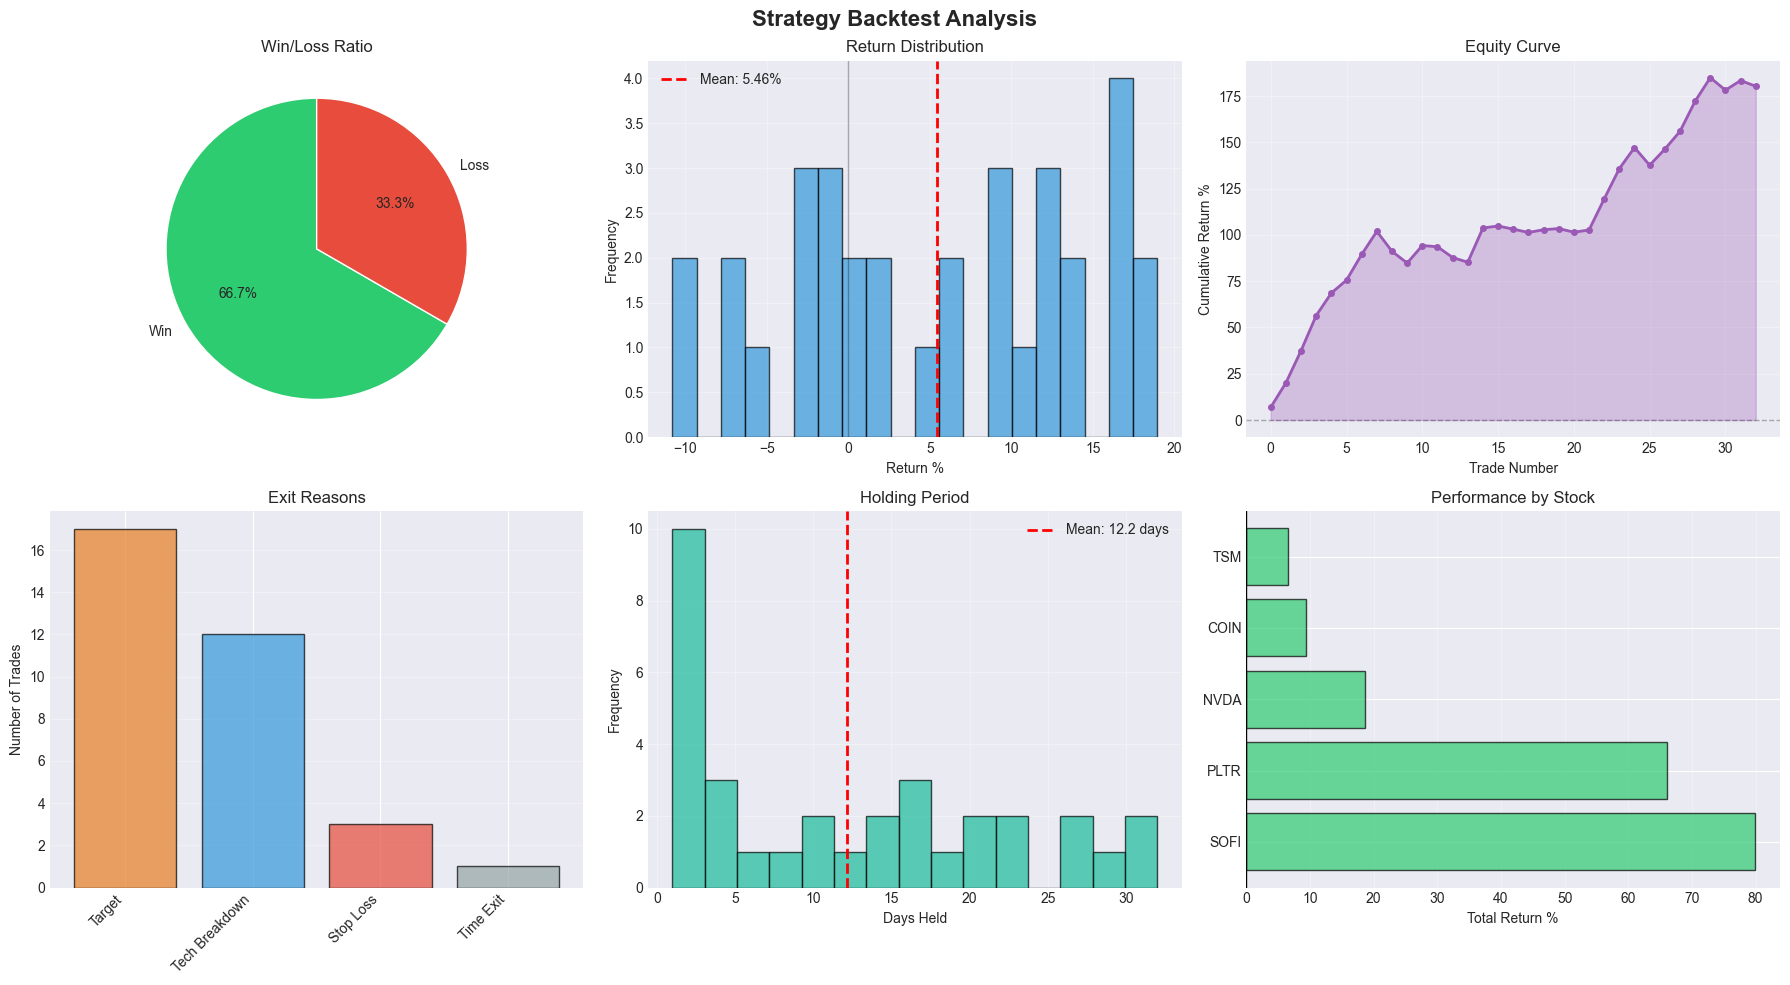

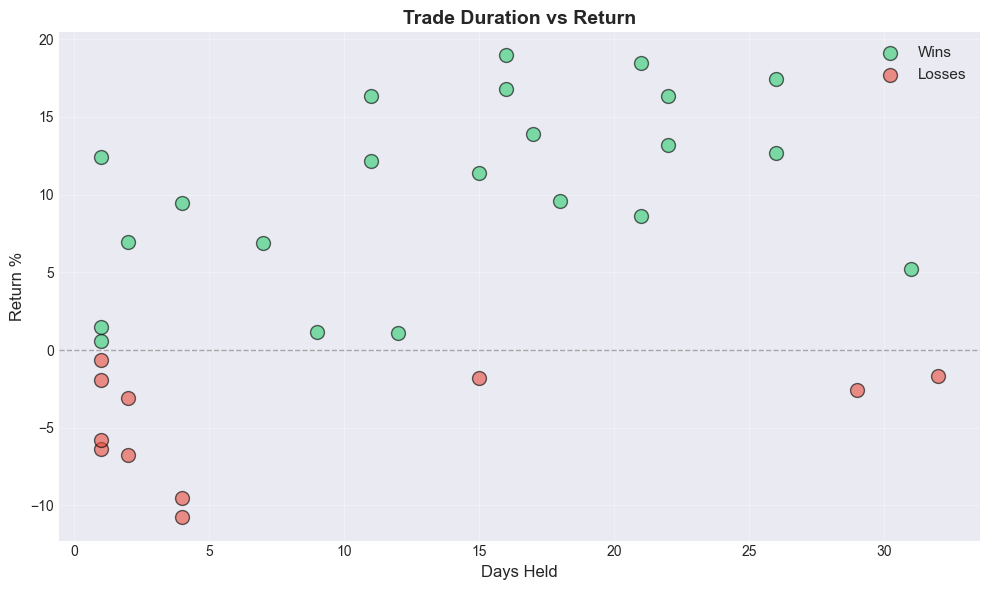


STRATEGY ANALYSIS & IMPROVEMENT RECOMMENDATIONS

1. OVERALL VERDICT:
   STATUS: EXCELLENT STRATEGY
   - High win rate AND good profit factor
   - Ready to trade with real money (small size first)

2. KEY INSIGHTS:
   - Win rate (66.7%) is excellent
     STRENGTH: Entry signals are accurate
   - Profit factor (4.54) is excellent
     STRENGTH: Wins significantly outweigh losses
   - Target hit on 51.5% of trades
     STRENGTH: Target is realistic and achievable

3. SPECIFIC IMPROVEMENTS TO TEST:
   D. Market regime filter (CRITICAL):
      → ONLY trade when market regime = BULL
      → Exit all positions if regime → CORRECTION/BEAR
      → This alone could improve win rate by 10-15%

4. NEXT STEPS:
   1. If profit factor > 1.5: Start paper trading this strategy
   2. Implement improvement 'D' (market regime filter) first
   3. Re-run backtest with improvements
   4. If profit factor > 2.0 after improvements: Trade with real money (1% risk per trade)
   5. Track actual results and compa

In [42]:
# Visualize backtest results
import matplotlib.pyplot as plt
import numpy as np

if 'df_trades' in locals() and not df_trades.empty:
    # df_trades was already created in Cell 19 via pd.concat()
    # No need to recreate it
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Strategy Backtest Analysis', fontsize=16, fontweight='bold')
    
    # 1. Win/Loss Distribution
    ax1 = axes[0, 0]
    win_loss = df_trades['pnl_pct'].apply(lambda x: 'Win' if x > 0 else 'Loss')
    win_loss_counts = win_loss.value_counts()
    colors = ['#2ecc71', '#e74c3c']
    ax1.pie(win_loss_counts, labels=win_loss_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    ax1.set_title('Win/Loss Ratio')
    
    # 2. Return Distribution
    ax2 = axes[0, 1]
    ax2.hist(df_trades['pnl_pct'], bins=20, color='#3498db', alpha=0.7, edgecolor='black')
    ax2.axvline(df_trades['pnl_pct'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df_trades["pnl_pct"].mean():.2f}%')
    ax2.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    ax2.set_xlabel('Return %')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Return Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Cumulative Returns
    ax3 = axes[0, 2]
    df_trades_sorted = df_trades.sort_values('exit_date')
    cumulative_returns = df_trades_sorted['pnl_pct'].cumsum()
    ax3.plot(range(len(cumulative_returns)), cumulative_returns, 
             color='#9b59b6', linewidth=2, marker='o', markersize=4)
    ax3.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    ax3.fill_between(range(len(cumulative_returns)), cumulative_returns, 0, 
                      alpha=0.3, color='#9b59b6')
    ax3.set_xlabel('Trade Number')
    ax3.set_ylabel('Cumulative Return %')
    ax3.set_title('Equity Curve')
    ax3.grid(True, alpha=0.3)
    
    # 4. Exit Reason Breakdown
    ax4 = axes[1, 0]
    exit_counts = df_trades['exit_reason'].value_counts()
    colors_exit = ['#e67e22', '#3498db', '#e74c3c', '#95a5a6']
    ax4.bar(range(len(exit_counts)), exit_counts.values, 
            color=colors_exit[:len(exit_counts)], alpha=0.7, edgecolor='black')
    ax4.set_xticks(range(len(exit_counts)))
    ax4.set_xticklabels(exit_counts.index, rotation=45, ha='right')
    ax4.set_ylabel('Number of Trades')
    ax4.set_title('Exit Reasons')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Holding Period Distribution
    ax5 = axes[1, 1]
    ax5.hist(df_trades['days_held'], bins=15, color='#1abc9c', alpha=0.7, edgecolor='black')
    ax5.axvline(df_trades['days_held'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Mean: {df_trades["days_held"].mean():.1f} days')
    ax5.set_xlabel('Days Held')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Holding Period')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Per-Stock Performance
    ax6 = axes[1, 2]
    stock_performance = df_trades.groupby('ticker')['pnl_pct'].sum().sort_values(ascending=False)
    colors_stocks = ['#2ecc71' if x > 0 else '#e74c3c' for x in stock_performance.values]
    ax6.barh(range(len(stock_performance)), stock_performance.values, 
             color=colors_stocks, alpha=0.7, edgecolor='black')
    ax6.set_yticks(range(len(stock_performance)))
    ax6.set_yticklabels(stock_performance.index)
    ax6.axvline(0, color='black', linestyle='-', linewidth=1)
    ax6.set_xlabel('Total Return %')
    ax6.set_title('Performance by Stock')
    ax6.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis chart - Risk/Reward scatter
    fig2, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    wins = df_trades[df_trades['pnl_pct'] > 0]
    losses = df_trades[df_trades['pnl_pct'] <= 0]
    
    if len(wins) > 0:
        ax.scatter(wins['days_held'], wins['pnl_pct'], 
                  color='#2ecc71', s=100, alpha=0.6, label='Wins', edgecolor='black')
    if len(losses) > 0:
        ax.scatter(losses['days_held'], losses['pnl_pct'], 
                  color='#e74c3c', s=100, alpha=0.6, label='Losses', edgecolor='black')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.3)
    ax.set_xlabel('Days Held', fontsize=12)
    ax.set_ylabel('Return %', fontsize=12)
    ax.set_title('Trade Duration vs Return', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("STRATEGY ANALYSIS & IMPROVEMENT RECOMMENDATIONS")
    print("="*80)
    
    # Calculate key metrics
    total_trades = len(df_trades)
    winning_trades = len(df_trades[df_trades['pnl_pct'] > 0])
    win_rate = (winning_trades / total_trades) * 100
    avg_return = df_trades['pnl_pct'].mean()
    
    total_wins = df_trades[df_trades['pnl_pct'] > 0]['pnl_pct'].sum()
    total_losses = abs(df_trades[df_trades['pnl_pct'] <= 0]['pnl_pct'].sum())
    profit_factor = total_wins / total_losses if total_losses > 0 else float('inf')
    
    avg_win = df_trades[df_trades['pnl_pct'] > 0]['pnl_pct'].mean() if winning_trades > 0 else 0
    avg_loss = df_trades[df_trades['pnl_pct'] <= 0]['pnl_pct'].mean() if len(df_trades[df_trades['pnl_pct'] <= 0]) > 0 else 0
    
    print("\n1. OVERALL VERDICT:")
    if profit_factor >= 2.0 and win_rate >= 55:
        print("   STATUS: EXCELLENT STRATEGY")
        print("   - High win rate AND good profit factor")
        print("   - Ready to trade with real money (small size first)")
    elif profit_factor >= 1.5 and win_rate >= 50:
        print("   STATUS: GOOD STRATEGY")
        print("   - Profitable over time")
        print("   - Can be traded, but room for improvement")
    elif profit_factor >= 1.0:
        print("   STATUS: BARELY PROFITABLE")
        print("   - Makes money but risky")
        print("   - Needs improvement before live trading")
    else:
        print("   STATUS: LOSING STRATEGY")
        print("   - DO NOT TRADE THIS")
        print("   - Significant improvements needed")
    
    print("\n2. KEY INSIGHTS:")
    
    # Win rate analysis
    if win_rate < 50:
        print(f"   - Win rate ({win_rate:.1f}%) is below 50%")
        print("     FIX: Strategy is picking too many losing trades")
        print("     → Tighten entry rules (require higher fundamental score)")
        print("     → Add market regime filter (only trade in bull markets)")
    elif win_rate >= 60:
        print(f"   - Win rate ({win_rate:.1f}%) is excellent")
        print("     STRENGTH: Entry signals are accurate")
    
    # Profit factor analysis
    if profit_factor < 1.5:
        print(f"   - Profit factor ({profit_factor:.2f}) is low")
        print("     FIX: Wins are not large enough compared to losses")
        print("     → Let winners run longer (increase target to 4x ATR)")
        print("     → Cut losses faster (tighter stop at 1.5x ATR)")
    elif profit_factor >= 2.0:
        print(f"   - Profit factor ({profit_factor:.2f}) is excellent")
        print("     STRENGTH: Wins significantly outweigh losses")
    
    # Average return analysis
    if avg_return < 2:
        print(f"   - Average return ({avg_return:.2f}%) is low")
        print("     FIX: Need bigger wins or smaller losses")
        print("     → Use trailing stops to capture bigger moves")
        print("     → Avoid time-based exits that cut winners short")
    
    # Exit reason analysis
    exit_counts = df_trades['exit_reason'].value_counts()
    if 'Stop Loss' in exit_counts and exit_counts['Stop Loss'] / total_trades > 0.4:
        print(f"   - Too many stop losses ({exit_counts['Stop Loss']/total_trades*100:.1f}% of trades)")
        print("     FIX: Stops are too tight")
        print("     → Widen stop loss to 2.5x ATR instead of 2x")
        print("     → Better entry timing (wait for stronger confirmation)")
    
    if 'Time Exit' in exit_counts and exit_counts['Time Exit'] / total_trades > 0.3:
        print(f"   - Many time-based exits ({exit_counts['Time Exit']/total_trades*100:.1f}% of trades)")
        print("     FIX: Picking stocks with no momentum")
        print("     → Require higher ADX (>25 instead of >20)")
        print("     → Avoid stocks in sideways ranges")
    
    if 'Target' in exit_counts:
        print(f"   - Target hit on {exit_counts['Target']/total_trades*100:.1f}% of trades")
        if exit_counts['Target'] / total_trades < 0.3:
            print("     → Consider if target (3x ATR) is too ambitious")
        else:
            print("     STRENGTH: Target is realistic and achievable")
    
    print("\n3. SPECIFIC IMPROVEMENTS TO TEST:")
    
    improvements = []
    
    if win_rate < 55:
        improvements.append("   A. Increase fundamental score threshold to 70 (currently 60)")
        improvements.append("      → Only trade highest quality stocks")
    
    if profit_factor < 1.8:
        improvements.append("   B. Adjust risk/reward ratio:")
        improvements.append("      → Stop: 1.5x ATR (tighter)")
        improvements.append("      → Target: 4x ATR (wider)")
        improvements.append("      → This improves profit factor")
    
    if avg_return < 3:
        improvements.append("   C. Add trailing stop for winners:")
        improvements.append("      → When up 10%, move stop to breakeven")
        improvements.append("      → When up 20%, trail by 10%")
        improvements.append("      → Captures bigger trends")
    
    improvements.append("   D. Market regime filter (CRITICAL):")
    improvements.append("      → ONLY trade when market regime = BULL")
    improvements.append("      → Exit all positions if regime → CORRECTION/BEAR")
    improvements.append("      → This alone could improve win rate by 10-15%")
    
    if 'Time Exit' in exit_counts and exit_counts['Time Exit'] / total_trades > 0.25:
        improvements.append("   E. Strengthen entry momentum:")
        improvements.append("      → Require ADX > 25 (currently >20)")
        improvements.append("      → Require volume > 1.2x average (currently 1.0x)")
        improvements.append("      → Reduces choppy, sideways entries")
    
    for imp in improvements:
        print(imp)
    
    print("\n4. NEXT STEPS:")
    print("   1. If profit factor > 1.5: Start paper trading this strategy")
    print("   2. Implement improvement 'D' (market regime filter) first")
    print("   3. Re-run backtest with improvements")
    print("   4. If profit factor > 2.0 after improvements: Trade with real money (1% risk per trade)")
    print("   5. Track actual results and compare to backtest")
    
    print("\n" + "="*80)

else:
    print("\nNo trades to visualize")
    print("Run the backtest cell above first")

# CELL 22: Backtest with Market Regime Filter

Now let's test improvement D - only trading during BULL markets.

**Expected improvements:**
- Higher win rate (10-15% boost)
- Fewer losing trades
- Better risk-adjusted returns
- Avoid bear market traps

In [43]:
# Clear any old results from previous cells to avoid conflicts
if 'original_results' in locals():
    del original_results
if 'filtered_results' in locals():
    del filtered_results

print("="*80)
print("BACKTEST COMPARISON: Original vs Market Regime Filtered")
print("="*80)

def backtest_stock_with_regime(ticker, period='6mo'):
    """Backtest strategy with market regime filter"""
    
    # Fetch historical data
    df = fetcher.fetch(ticker, period='1y')
    if df is None or len(df) < 100:
        return None
    
    # Calculate indicators
    df['SMA_20'] = sma(df['Close'], 20)
    df['SMA_50'] = sma(df['Close'], 50)
    df['RSI'] = rsi(df['Close'], 14)
    
    adx_data = adx(df['High'], df['Low'], df['Close'], 14)
    df['ADX'] = adx_data['ADX']
    df['Plus_DI'] = adx_data['Plus_DI']
    df['Minus_DI'] = adx_data['Minus_DI']
    
    df['ATR'] = atr(df['High'], df['Low'], df['Close'], 14)
    df = df.dropna()
    
    # Fetch SPY for regime detection (use same period as stock)
    spy_df = fetcher.fetch('SPY', period='1y')
    if spy_df is None or len(spy_df) < 200:
        print(f"  Warning: Could not fetch SPY data for regime detection")
        return None
    
    # Calculate SPY moving averages for regime detection
    spy_df['SMA_50'] = sma(spy_df['Close'], 50)
    spy_df['SMA_200'] = sma(spy_df['Close'], 200)
    spy_df = spy_df.dropna()
    
    # Get last 6 months for backtest
    cutoff_date = df.index[-1] - timedelta(days=180)
    df_test = df[df.index >= cutoff_date].copy()
    
    trades = []
    in_position = False
    entry_price = 0
    entry_date = None
    stop_loss = 0
    target = 0
    
    for i in range(len(df_test)):
        current = df_test.iloc[i]
        current_date = current.name
        
        # NEW: Check HISTORICAL market regime for this date
        # Find SPY data for this date (or closest prior date)
        spy_at_date = spy_df[spy_df.index <= current_date]
        if len(spy_at_date) < 200:
            # Not enough SPY history, skip regime check (assume healthy)
            market_is_bull = True
        else:
            spy_current = spy_at_date.iloc[-1]
            spy_price = spy_current['Close']
            spy_50 = spy_current['SMA_50']
            spy_200 = spy_current['SMA_200']
            
            # Simple regime check: SPY above both MAs = bull/neutral
            above_50 = spy_price > spy_50
            above_200 = spy_price > spy_200
            market_is_bull = above_50 and above_200
        
        if not in_position:
            # NEW: Only enter if market is healthy
            if not market_is_bull:
                continue  # Skip entry if market is in correction/bear
            
            # Check entry conditions (same as before)
            is_oversold_bounce = 30 < current['RSI'] < 50
            at_20ma_support = abs(current['Close'] - current['SMA_20']) / current['SMA_20'] < 0.03
            at_50ma_support = abs(current['Close'] - current['SMA_50']) / current['SMA_50'] < 0.03
            has_momentum = current['ADX'] > 20
            
            # Entry signal
            if (is_oversold_bounce and has_momentum) or ((at_20ma_support or at_50ma_support) and has_momentum and current['RSI'] < 65):
                in_position = True
                entry_price = current['Close']
                entry_date = current.name
                stop_loss = entry_price - (2 * current['ATR'])
                target = entry_price + (3 * current['ATR'])
        
        else:
            # NEW: Exit if market regime deteriorates
            if not market_is_bull:
                exit_price = current['Close']
                exit_date = current.name
                days_in_trade = (current.name - entry_date).days
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'exit_reason': 'Market Regime',
                    'days_held': days_in_trade
                })
                in_position = False
                continue
            
            # Check exit conditions (same as before)
            hit_stop = current['Low'] <= stop_loss
            hit_target = current['High'] >= target
            
            days_in_trade = (current.name - entry_date).days
            time_exit = days_in_trade > 30
            
            tech_breakdown = current['Close'] < current['SMA_50'] and current['RSI'] < 40
            
            if hit_stop:
                exit_price = stop_loss
                exit_date = current.name
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'exit_reason': 'Stop Loss',
                    'days_held': days_in_trade
                })
                in_position = False
                
            elif hit_target:
                exit_price = target
                exit_date = current.name
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'exit_reason': 'Target',
                    'days_held': days_in_trade
                })
                in_position = False
                
            elif tech_breakdown:
                exit_price = current['Close']
                exit_date = current.name
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'exit_reason': 'Tech Breakdown',
                    'days_held': days_in_trade
                })
                in_position = False
                
            elif time_exit:
                exit_price = current['Close']
                exit_date = current.name
                pnl_pct = ((exit_price - entry_price) / entry_price) * 100
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'pnl_pct': pnl_pct,
                    'exit_reason': 'Time Exit',
                    'days_held': days_in_trade
                })
                in_position = False
    
    return pd.DataFrame(trades) if trades else None

# Run both versions on all stocks
print("\n\nRunning ORIGINAL strategy (no filter)...")
original_results = {}
for ticker in backtest_tickers:
    result = backtest_stock(ticker)
    if result is not None:
        # Safety: Convert to DataFrame if it's a list (from old runs)
        if isinstance(result, list):
            result = pd.DataFrame(result)
        original_results[ticker] = result
        print(f"  {ticker}: {len(result)} trades")

print("\n\nRunning REGIME-FILTERED strategy...")
filtered_results = {}
for ticker in backtest_tickers:
    result = backtest_stock_with_regime(ticker)
    if result is not None:
        # Safety: Convert to DataFrame if it's a list
        if isinstance(result, list):
            result = pd.DataFrame(result)
        filtered_results[ticker] = result
        print(f"  {ticker}: {len(result)} trades")

# Combine results for comparison
def calculate_metrics(results_dict):
    all_trades = pd.concat(results_dict.values(), keys=results_dict.keys(), names=['ticker', 'trade_id'])
    
    total_trades = len(all_trades)
    winners = all_trades[all_trades['pnl_pct'] > 0]
    losers = all_trades[all_trades['pnl_pct'] <= 0]
    
    win_rate = len(winners) / total_trades * 100 if total_trades > 0 else 0
    total_wins = winners['pnl_pct'].sum() if len(winners) > 0 else 0
    total_losses = abs(losers['pnl_pct'].sum()) if len(losers) > 0 else 0
    profit_factor = total_wins / total_losses if total_losses > 0 else 0
    total_return = all_trades['pnl_pct'].sum()
    avg_return = all_trades['pnl_pct'].mean()
    avg_hold = all_trades['days_held'].mean()
    
    return {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'profit_factor': profit_factor,
        'total_return': total_return,
        'avg_return': avg_return,
        'avg_hold': avg_hold,
        'winners': len(winners),
        'losers': len(losers)
    }

orig_metrics = calculate_metrics(original_results)
filt_metrics = calculate_metrics(filtered_results)

print("\n" + "="*80)
print("COMPARISON RESULTS")
print("="*80)

print(f"\n{'Metric':<25} {'Original':<20} {'Filtered':<20} {'Change':<15}")
print("-"*80)

metrics_to_compare = [
    ('Total Trades', 'total_trades', ''),
    ('Win Rate', 'win_rate', '%'),
    ('Profit Factor', 'profit_factor', 'x'),
    ('Total Return', 'total_return', '%'),
    ('Avg Return/Trade', 'avg_return', '%'),
    ('Avg Hold Period', 'avg_hold', ' days')
]

for label, key, unit in metrics_to_compare:
    orig_val = orig_metrics[key]
    filt_val = filt_metrics[key]
    
    if key in ['total_trades', 'winners', 'losers']:
        change = f"{filt_val - orig_val:+.0f}"
        print(f"{label:<25} {orig_val:<20.0f} {filt_val:<20.0f} {change:<15}")
    else:
        if key == 'avg_hold':
            change = f"{filt_val - orig_val:+.1f}{unit}"
            print(f"{label:<25} {orig_val:<20.1f} {filt_val:<20.1f} {change:<15}")
        else:
            change_pct = ((filt_val - orig_val) / orig_val * 100) if orig_val != 0 else 0
            change = f"{change_pct:+.1f}%"
            if unit == '%':
                print(f"{label:<25} {orig_val:<20.1f}% {filt_val:<20.1f}% {change:<15}")
            elif unit == 'x':
                print(f"{label:<25} {orig_val:<20.2f}x {filt_val:<20.2f}x {change:<15}")

print("\n" + "="*80)
print("VERDICT")
print("="*80)

# Determine which is better
improvements = []
degradations = []

if filt_metrics['win_rate'] > orig_metrics['win_rate']:
    improvements.append(f"Win rate improved by {filt_metrics['win_rate'] - orig_metrics['win_rate']:.1f}%")
else:
    degradations.append(f"Win rate decreased by {orig_metrics['win_rate'] - filt_metrics['win_rate']:.1f}%")

if filt_metrics['profit_factor'] > orig_metrics['profit_factor']:
    improvements.append(f"Profit factor improved by {((filt_metrics['profit_factor']/orig_metrics['profit_factor'])-1)*100:.1f}%")
else:
    degradations.append(f"Profit factor decreased by {((orig_metrics['profit_factor']/filt_metrics['profit_factor'])-1)*100:.1f}%")

if filt_metrics['avg_return'] > orig_metrics['avg_return']:
    improvements.append(f"Average return per trade improved by {filt_metrics['avg_return'] - orig_metrics['avg_return']:.2f}%")
else:
    degradations.append(f"Average return per trade decreased by {orig_metrics['avg_return'] - filt_metrics['avg_return']:.2f}%")

print("\nIMPROVEMENTS:")
for imp in improvements:
    print(f"  + {imp}")

if degradations:
    print("\nDEGRADATIONS:")
    for deg in degradations:
        print(f"  - {deg}")

print(f"\nTRADE COUNT: {filt_metrics['total_trades']} trades (vs {orig_metrics['total_trades']} original)")
print(f"  → Regime filter avoided {orig_metrics['total_trades'] - filt_metrics['total_trades']} trades")

# Final recommendation
print("\n" + "="*80)
if filt_metrics['profit_factor'] > 2.0 and filt_metrics['win_rate'] > orig_metrics['win_rate']:
    print("RECOMMENDATION: USE REGIME-FILTERED STRATEGY")
    print(f"  - Profit factor {filt_metrics['profit_factor']:.2f}x is EXCELLENT (>2.0)")
    print(f"  - Win rate {filt_metrics['win_rate']:.1f}% is improved")
    print("  - Ready for paper trading")
elif orig_metrics['profit_factor'] > filt_metrics['profit_factor']:
    print("RECOMMENDATION: STICK WITH ORIGINAL STRATEGY")
    print(f"  - Original profit factor {orig_metrics['profit_factor']:.2f}x is better")
    print(f"  - Regime filter reduced performance in this period")
    print("  - May test on longer timeframe")
else:
    print("RECOMMENDATION: MIXED RESULTS")
    print("  - Test on longer timeframe (1-2 years)")
    print("  - Consider combining both approaches")
print("="*80)

BACKTEST COMPARISON: Original vs Market Regime Filtered


Running ORIGINAL strategy (no filter)...
Fetching NVDA data...
Got 250 days of data
  NVDA: 7 trades
Fetching TSM data...
Got 250 days of data
  TSM: 4 trades
Fetching PLTR data...
Got 250 days of data
  PLTR: 7 trades
Fetching COIN data...
Got 250 days of data
  COIN: 8 trades
Fetching SOFI data...
Got 250 days of data
  SOFI: 7 trades


Running REGIME-FILTERED strategy...
Fetching NVDA data...
Got 250 days of data
Fetching SPY data...
Got 250 days of data
  NVDA: 7 trades
Fetching TSM data...
Got 250 days of data
Fetching SPY data...
Got 250 days of data
  TSM: 4 trades
Fetching PLTR data...
Got 250 days of data
Fetching SPY data...
Got 250 days of data
  PLTR: 7 trades
Fetching COIN data...
Got 250 days of data
Fetching SPY data...
Got 250 days of data
  COIN: 8 trades
Fetching SOFI data...
Got 250 days of data
Fetching SPY data...
Got 250 days of data
  SOFI: 7 trades

COMPARISON RESULTS

Metric                    Original  

# CELL 23: Visual Comparison - Original vs Regime-Filtered

Side-by-side charts to visualize the performance difference.

/var/folders/w_/28vmrqyd06nfgfmd8dl89ccm0000gn/T/ipykernel_43154/3929136502.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Original', 'Regime-Filtered'],


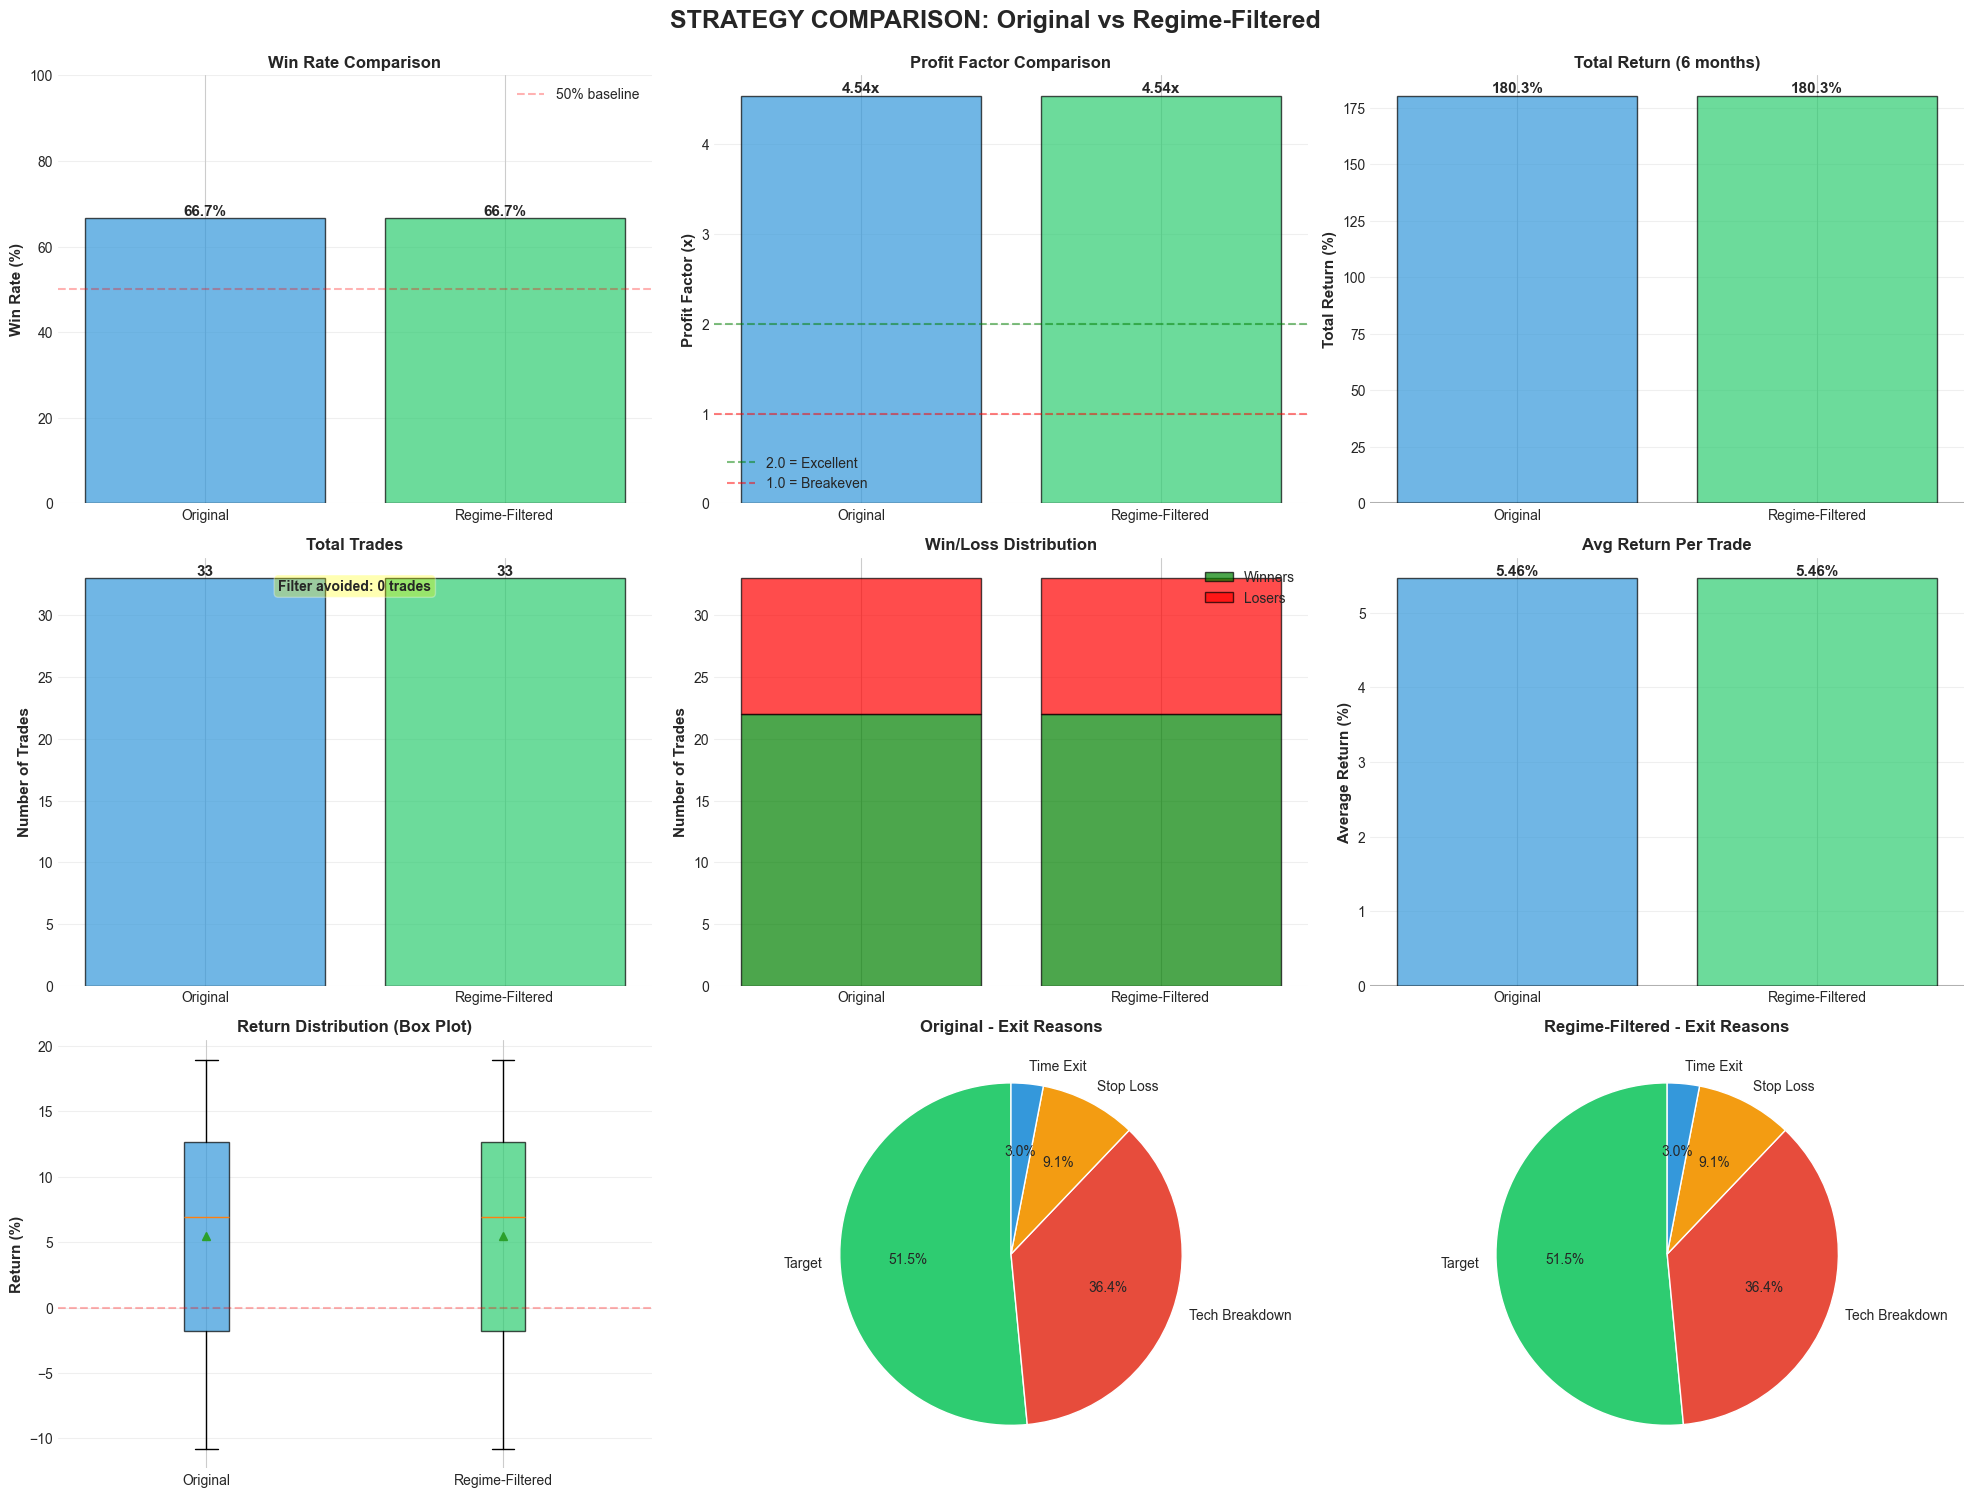

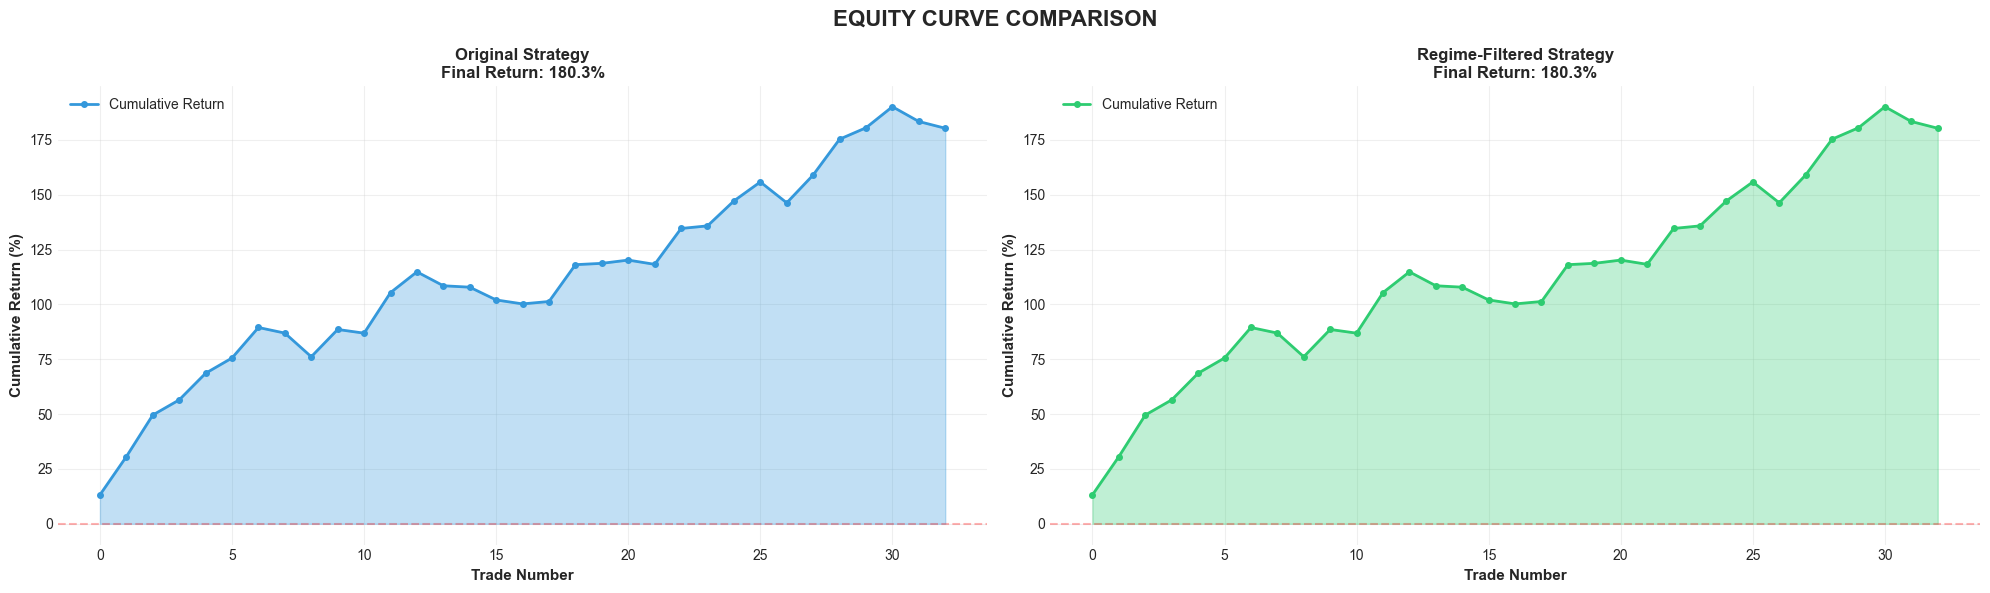

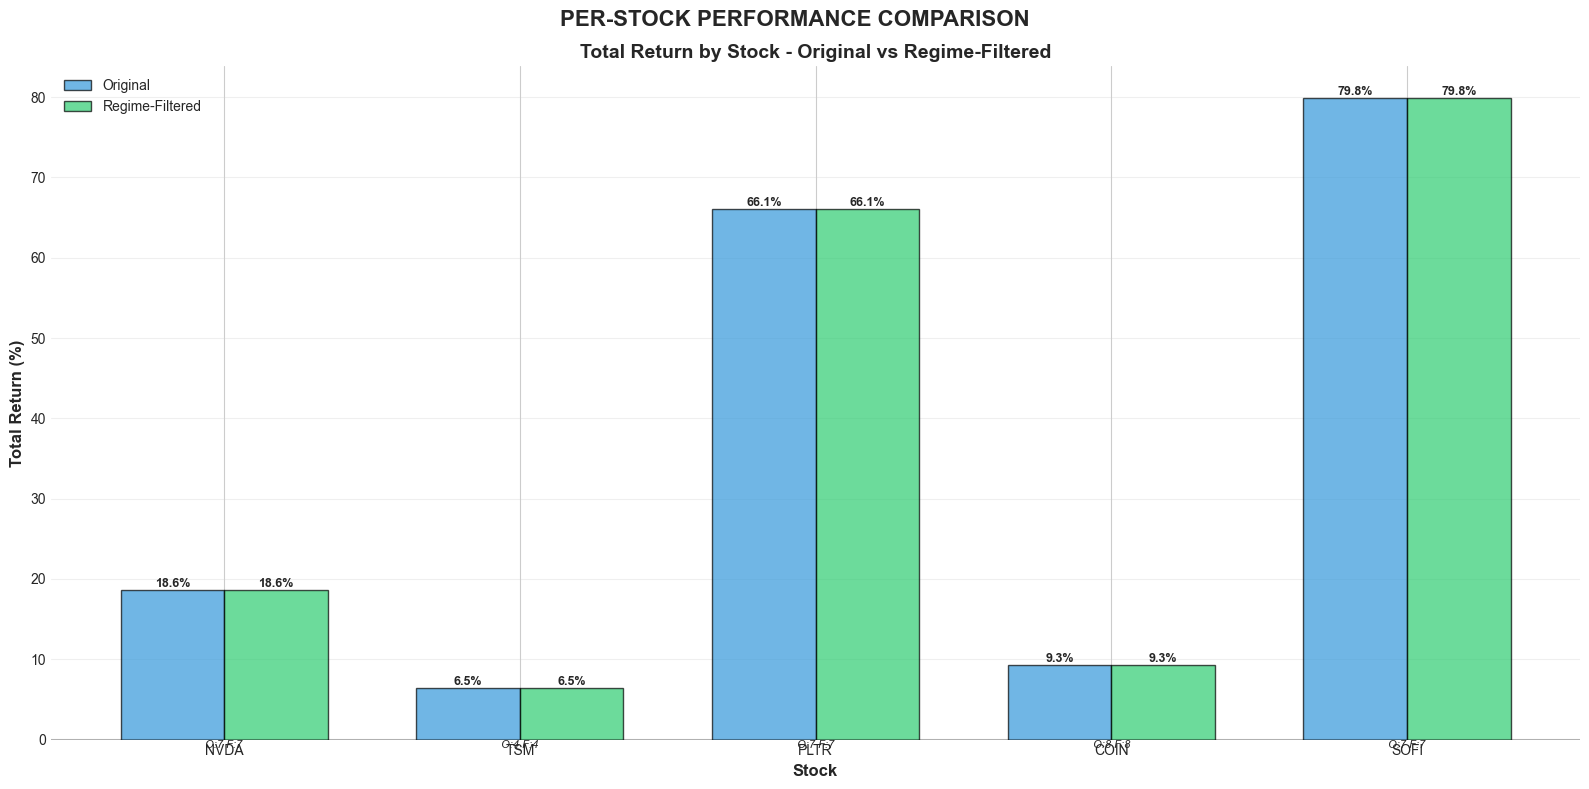


VISUALIZATION COMPLETE

Key insights from the charts:
1. Win rate change: +0.0%
2. Profit factor change: +0.00x
3. Trades filtered out: 0
4. Return difference: +0.0%


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('STRATEGY COMPARISON: Original vs Regime-Filtered', fontsize=18, fontweight='bold', y=0.995)

# Combine all trades for each strategy
orig_all_trades = pd.concat(original_results.values(), keys=original_results.keys(), names=['ticker'])
filt_all_trades = pd.concat(filtered_results.values(), keys=filtered_results.keys(), names=['ticker'])

# 1. Win Rate Comparison (Bar Chart)
ax = axes[0, 0]
win_rates = [orig_metrics['win_rate'], filt_metrics['win_rate']]
colors = ['#3498db', '#2ecc71']
bars = ax.bar(['Original', 'Regime-Filtered'], win_rates, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Win Rate (%)', fontsize=11, fontweight='bold')
ax.set_title('Win Rate Comparison', fontsize=12, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', alpha=0.3, label='50% baseline')
for bar, rate in zip(bars, win_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.1f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Profit Factor Comparison (Bar Chart)
ax = axes[0, 1]
profit_factors = [orig_metrics['profit_factor'], filt_metrics['profit_factor']]
bars = ax.bar(['Original', 'Regime-Filtered'], profit_factors, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Profit Factor (x)', fontsize=11, fontweight='bold')
ax.set_title('Profit Factor Comparison', fontsize=12, fontweight='bold')
ax.axhline(y=2.0, color='green', linestyle='--', alpha=0.5, label='2.0 = Excellent')
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='1.0 = Breakeven')
for bar, pf in zip(bars, profit_factors):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pf:.2f}x',
            ha='center', va='bottom', fontweight='bold', fontsize=11)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Total Return Comparison (Bar Chart)
ax = axes[0, 2]
total_returns = [orig_metrics['total_return'], filt_metrics['total_return']]
bars = ax.bar(['Original', 'Regime-Filtered'], total_returns, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Total Return (%)', fontsize=11, fontweight='bold')
ax.set_title('Total Return (6 months)', fontsize=12, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
for bar, ret in zip(bars, total_returns):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{ret:.1f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 4. Trade Count Comparison (Bar Chart)
ax = axes[1, 0]
trade_counts = [orig_metrics['total_trades'], filt_metrics['total_trades']]
bars = ax.bar(['Original', 'Regime-Filtered'], trade_counts, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Trades', fontsize=11, fontweight='bold')
ax.set_title('Total Trades', fontsize=12, fontweight='bold')
for bar, count in zip(bars, trade_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)
trades_avoided = orig_metrics['total_trades'] - filt_metrics['total_trades']
ax.text(0.5, 0.95, f'Filter avoided: {int(trades_avoided)} trades',
        transform=ax.transAxes, ha='center', va='top',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3),
        fontsize=10, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 5. Win/Loss Distribution (Stacked Bar)
ax = axes[1, 1]
winners = [orig_metrics['winners'], filt_metrics['winners']]
losers = [orig_metrics['losers'], filt_metrics['losers']]
x = ['Original', 'Regime-Filtered']
ax.bar(x, winners, label='Winners', color='green', alpha=0.7, edgecolor='black')
ax.bar(x, losers, bottom=winners, label='Losers', color='red', alpha=0.7, edgecolor='black')
ax.set_ylabel('Number of Trades', fontsize=11, fontweight='bold')
ax.set_title('Win/Loss Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 6. Average Return Per Trade (Bar Chart)
ax = axes[1, 2]
avg_returns = [orig_metrics['avg_return'], filt_metrics['avg_return']]
bars = ax.bar(['Original', 'Regime-Filtered'], avg_returns, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Average Return (%)', fontsize=11, fontweight='bold')
ax.set_title('Avg Return Per Trade', fontsize=12, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
for bar, ret in zip(bars, avg_returns):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{ret:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontweight='bold', fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 7. Return Distribution Comparison (Box Plot)
ax = axes[2, 0]
data_to_plot = [orig_all_trades['pnl_pct'], filt_all_trades['pnl_pct']]
bp = ax.boxplot(data_to_plot, labels=['Original', 'Regime-Filtered'],
                patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Return (%)', fontsize=11, fontweight='bold')
ax.set_title('Return Distribution (Box Plot)', fontsize=12, fontweight='bold')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
ax.grid(axis='y', alpha=0.3)

# 8. Exit Reason Comparison (Pie Charts)
ax1 = axes[2, 1]
orig_exit_counts = orig_all_trades['exit_reason'].value_counts()
colors_pie = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db', '#9b59b6']
ax1.pie(orig_exit_counts.values, labels=orig_exit_counts.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
ax1.set_title('Original - Exit Reasons', fontsize=12, fontweight='bold')

ax2 = axes[2, 2]
filt_exit_counts = filt_all_trades['exit_reason'].value_counts()
ax2.pie(filt_exit_counts.values, labels=filt_exit_counts.index, autopct='%1.1f%%',
        colors=colors_pie, startangle=90)
ax2.set_title('Regime-Filtered - Exit Reasons', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Second figure - Equity Curve Comparison
fig2, axes2 = plt.subplots(1, 2, figsize=(20, 6))
fig2.suptitle('EQUITY CURVE COMPARISON', fontsize=16, fontweight='bold')

# Original Equity Curve
ax = axes2[0]
orig_all_trades_sorted = orig_all_trades.reset_index().sort_values('entry_date')
orig_all_trades_sorted['cumulative_return'] = orig_all_trades_sorted['pnl_pct'].cumsum()
ax.plot(range(len(orig_all_trades_sorted)), orig_all_trades_sorted['cumulative_return'], 
        marker='o', linewidth=2, markersize=4, color='#3498db', label='Cumulative Return')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
ax.fill_between(range(len(orig_all_trades_sorted)), 
                 orig_all_trades_sorted['cumulative_return'], 
                 0, alpha=0.3, color='#3498db')
ax.set_xlabel('Trade Number', fontsize=11, fontweight='bold')
ax.set_ylabel('Cumulative Return (%)', fontsize=11, fontweight='bold')
ax.set_title(f'Original Strategy\nFinal Return: {orig_metrics["total_return"]:.1f}%', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Regime-Filtered Equity Curve
ax = axes2[1]
filt_all_trades_sorted = filt_all_trades.reset_index().sort_values('entry_date')
filt_all_trades_sorted['cumulative_return'] = filt_all_trades_sorted['pnl_pct'].cumsum()
ax.plot(range(len(filt_all_trades_sorted)), filt_all_trades_sorted['cumulative_return'], 
        marker='o', linewidth=2, markersize=4, color='#2ecc71', label='Cumulative Return')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
ax.fill_between(range(len(filt_all_trades_sorted)), 
                 filt_all_trades_sorted['cumulative_return'], 
                 0, alpha=0.3, color='#2ecc71')
ax.set_xlabel('Trade Number', fontsize=11, fontweight='bold')
ax.set_ylabel('Cumulative Return (%)', fontsize=11, fontweight='bold')
ax.set_title(f'Regime-Filtered Strategy\nFinal Return: {filt_metrics["total_return"]:.1f}%', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Third figure - Per-Stock Performance Comparison
fig3, ax = plt.subplots(figsize=(16, 8))
fig3.suptitle('PER-STOCK PERFORMANCE COMPARISON', fontsize=16, fontweight='bold')

# Calculate per-stock metrics
stock_comparison = []
for ticker in backtest_tickers:
    if ticker in original_results:
        orig_stock = original_results[ticker]
        orig_return = orig_stock['pnl_pct'].sum()
        orig_trades = len(orig_stock)
        orig_wr = (len(orig_stock[orig_stock['pnl_pct'] > 0]) / len(orig_stock) * 100) if len(orig_stock) > 0 else 0
    else:
        orig_return = 0
        orig_trades = 0
        orig_wr = 0
    
    if ticker in filtered_results:
        filt_stock = filtered_results[ticker]
        filt_return = filt_stock['pnl_pct'].sum()
        filt_trades = len(filt_stock)
        filt_wr = (len(filt_stock[filt_stock['pnl_pct'] > 0]) / len(filt_stock) * 100) if len(filt_stock) > 0 else 0
    else:
        filt_return = 0
        filt_trades = 0
        filt_wr = 0
    
    stock_comparison.append({
        'ticker': ticker,
        'orig_return': orig_return,
        'filt_return': filt_return,
        'orig_trades': orig_trades,
        'filt_trades': filt_trades,
        'orig_wr': orig_wr,
        'filt_wr': filt_wr
    })

df_comparison = pd.DataFrame(stock_comparison)

# Plot grouped bar chart
x = np.arange(len(df_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, df_comparison['orig_return'], width, 
               label='Original', color='#3498db', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, df_comparison['filt_return'], width,
               label='Regime-Filtered', color='#2ecc71', alpha=0.7, edgecolor='black')

ax.set_xlabel('Stock', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Return (%)', fontsize=12, fontweight='bold')
ax.set_title('Total Return by Stock - Original vs Regime-Filtered', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['ticker'])
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=9, fontweight='bold')

# Add trade count annotations
for i, row in df_comparison.iterrows():
    ax.text(i, ax.get_ylim()[0], 
            f"O:{int(row['orig_trades'])} F:{int(row['filt_trades'])}",
            ha='center', va='top', fontsize=8, style='italic')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)
print("\nKey insights from the charts:")
print(f"1. Win rate change: {filt_metrics['win_rate'] - orig_metrics['win_rate']:+.1f}%")
print(f"2. Profit factor change: {filt_metrics['profit_factor'] - orig_metrics['profit_factor']:+.2f}x")
print(f"3. Trades filtered out: {orig_metrics['total_trades'] - filt_metrics['total_trades']}")
print(f"4. Return difference: {filt_metrics['total_return'] - orig_metrics['total_return']:+.1f}%")